In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

from collections import Counter # for mAP

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

from torchvision.ops import complete_box_iou_loss, distance_box_iou_loss

import cv2

/opt/conda/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [44]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = 'results/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('SqueeNet Model')

# Folders

In [4]:
ds_dir = '../../ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels - copia.cache', 'labels.cache', 'labels', 'images']
val dir: ['.ipynb_checkpoints', 'labels', 'images']


# Config

In [5]:
CLASSES = ["smoke", "fire"]
#CLASSES = ["cat", "dog"]

#IMG_DIM = {'W':88, 'H':88} # (W, H)
#IMG_DIM = {'W':160, 'H':120} # (W, H)
#IMG_DIM = {'W':448, 'H':448} # (W, H)
IMG_DIM = {'W':224, 'H':224} # (W, H)

SX = 6
SY = 6
B = 2 # Number of bounding boxes to predict.
C = len(CLASSES) # Number of classes in the dataset.

# Utils

In [6]:
def yolo2pixel(bbox):
    '''
    Transforms yolo coordinates of the box to pixel coordinates. 
    
    Arguments:
        - bbox: yolo coordinates [xc, yc, width, height]
    
    Returns: 
        - pixel coordinates [xmin, xmax, ymin, ymax]
    '''
    xc = bbox[0]
    yc = bbox[1]
    width = bbox[2]
    height = bbox[3]
      
    xmin = xc - (width/2)          
    xmax = xc + (width/2)         
    ymin = yc - (height/2)            
    ymax = yc + (height/2)
        
    nbox = [xmin, ymin, xmax, ymax]
    
    return nbox


def iou_tensor(
    boxes_preds, boxes_labels, 
    box_format="midpoint",
    epsilon=1e-6
):
    """
    Calculates intersection over union for bounding boxes.
    
    :param boxes_preds (tensor): Bounding box predictions of shape (BATCH_SIZE, 4)
    :param boxes_labels (tensor): Ground truth bounding box of shape (BATCH_SIZE, 4)
    :param box_format (str): midpoint/corners, if boxes (x,y,w,h) format or (x1,y1,x2,y2) format
    :param epsilon: Small value to prevent division by zero.
    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == 'midpoint':
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == 'corners':
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4] 
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    union = (box1_area + box2_area - intersection + epsilon)

    iou = intersection / union
    #print(f'IOU is numpy: {iou.numpy()}')

    return iou

def nms_yv1(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [x1, y1, x2, y2, confidence, class_id] MY FORMAT VERSION       
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[4] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[4], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[5] != chosen_box[5]
            or iou_tensor(
                torch.tensor(chosen_box[:4]),
                torch.tensor(box[:4]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

def nms_yv1_getBBoxes(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_id, score, xc, yc, w, h] Output of outcell_2_outboxes       
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or iou_tensor(
                torch.tensor(chosen_box[2:6]),
                torch.tensor(box[2:6]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms



def mAP(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=2
):
    """
    Calculates mean average precision 

    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes

    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []
    avg_prec = {}

    # Precision and Recall for each class
    cls_prec = {}
    cls_rec = {}

    # used for numerical stability later on
    epsilon = 1e-6

    #for c in range(num_classes):
    for c in tqdm(range(num_classes), desc ="mAP:@.5"):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)
        
        #print(f'Detections of class {c}: {detections}')
        
        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])
        
        #print(f'Amount bboxes of class {c}: {amount_bboxes}')

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        #print(f'Amount bboxes of class {c} converted: {amount_bboxes}')
        
        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
       
        #print(f'Total true bboxes of class {c}: {total_true_bboxes}')
        
        # If none exists for this class then we can safely skip
        # Maybe removing this is enough to take into account False Positives
        # for images with no objects
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = iou_tensor(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )
                # iou, _, _ = ut.iou(detection[3:], 
                #                    gt[3:]) 

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        #print(f'True Positives class {c}: {TP}')
        #print(f'False Positives class {c}: {FP}')

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)

        if precisions.numel() > 0:
            #cls_prec.update({c: precisions[-1].numpy()})
            cls_prec.update({c: precisions[-1].item()})
        else:
            cls_prec.update({c: 0.})
        if recalls.numel() > 0:
            #cls_rec.update({c: recalls[-1].numpy()})
            cls_rec.update({c: recalls[-1].item()})
        else:
            cls_rec.update({c: 0.})

        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))
        avg_prec.update({c: torch.trapz(precisions, recalls)})

        if c == 0:
            class_name = "smoke"
        elif c == 1:
            class_name = "fire"
        else:
            print("Wrong class")
            raise SystemExit("Wrong class in mAP")
        plt.plot(recalls, precisions)
        plt.title("Precision-Recall Curve")
        plt.ylim([0,1])
        plt.xlim([0,1])
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.grid()
        plt.savefig(log_path + class_name + "_pre_rec_curve.png")
        plt.close()

    mAP = sum(average_precisions) / (len(average_precisions) + epsilon)

    #return mAP, average_precisions, cls_prec, cls_rec
    return (mAP, 
            avg_prec,
            cls_prec, 
            cls_rec)


def get_bboxes(
    loader,
    model,
    SX,
    SY,
    B,
    C,
    mask,
    iou_threshold,
    threshold,
    device,
    box_format="midpoint"):
    
    
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    loop = tqdm(loader, desc='Get Boxes', leave=True)
    #for batch_idx, (imgs, labels, _, _) in enumerate(loader):
    #for batch_idx, (imgs, labels) in enumerate(loader):
    for batch_idx, (imgs, labels) in enumerate(loop):
        imgs = imgs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(imgs)

        batch_size = imgs.shape[0]
        true_bboxes = outcell_2_outboxes(out_cells=labels, 
                                         SX=SX, SY=SY, B=B, C=C, 
                                         mask=mask, 
                                         device='cpu', # Changed to cpu
                                         is_pred=False)
        bboxes = outcell_2_outboxes(out_cells=predictions, 
                                    SX=SX, SY=SY, B=B, C=C, 
                                    mask=mask, 
                                    device='cpu', # Changed to cpu
                                    is_pred=True)

        for idx in range(batch_size):
            #nms_boxes = nms_yv1(
            nms_boxes = nms_yv1_getBBoxes(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format, # Midpoint, to use iou_tensor inside
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred, as bboxes have Conf = 1 and the rest are 0
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes


def outcell_2_outboxes(out_cells, SX, SY, B, C, mask, device, is_pred = True):
    '''
    Convert batch of cells to batch of boxes: out_cells must be of shape (BATCH_SIZE, SX, SY, B*5+C) 
        [xcel, ycel, w, h, conf, class_0, class_1] -> [pred_class, score, xc, yc, w, h]
    
    Arguments:
        - out_cells: labels at loader output or predictions at model output
            Format: [xcel, ycel, w, h, conf, class_0, class_1]
    Return:
        - all_bboxes: list of bounding boxes
            Format: [[bboxes idx 0], [bboxes idx 1], ... [bboxes idx BATCH_SIZE-1]]
    '''

    out_cells = out_cells.to(device) # TAKE A LOOK TO CPU DECISION

    out_cells[out_cells <= 0] = 0 # Zeroing all negative values. Avoid (-conf * -class_id) = +score
    #out_cells[out_cells >= 1] = 1 # Clamping all values to 1. Avoid being out of the image. Maybe afterwards, although it does not hurt here.
                                   # This is due to yolo2pixel transformation, which could led to out of image values, depending on (w, h)

    batch_size = out_cells.shape[0]
    if is_pred:
        out_cells = out_cells.reshape(batch_size, SY, SX, B*5+C)
    else:
        out_cells = out_cells.reshape(batch_size, SY, SX, 5+C)
    
    # With 2 BBoxes, choose the one with highest confidence. How highest IOU, without label?
    if (B>1 and is_pred):
        '''
        2 BB: [xcell, ycell, w, h, confidence_A, xcell, ycell, w, h, confidence_B, class_0, class_1]
        '''
        bbox1 = out_cells[..., :4]
        bbox2 = out_cells[..., 5:9]
        score = torch.cat((out_cells[..., 4:5],out_cells[..., 9:10]), dim=-1)
        best_score, idx = torch.max(score, dim=-1, keepdim=True)

        bestbbox = (1-idx)*bbox1 + idx*bbox2

        #class_prob = a[..., 10:12] # Esto no hace falta, se hace debajo
        #cls_pred = class_prob.argmax(dim=-1, keepdim=True)
        out_cells = torch.cat((bestbbox, best_score, out_cells[..., 10:12]), dim=-1)
        
    
    # All cells are converted to boxes. Format will be [xc, yc, w, h, conf, class_0, class_1]
    boxes = cell2boxes(cells = out_cells, mask = mask)

    # ================================================================================================================== #
    #                                                                                                                    #
    #     Convert [xc, yc, w, h, conf, class_0, class_1] to [pred_class, score, xc, yc, w, h]                            #
    #         Identify class predicted: class_0 > class_1 ??? or the opposite                                            #
    #         Multiply (conf * class_id) to get score and compare to threshold afterwards. It will be 1 for ground truth #
    #                                                                                                                    #
    # ================================================================================================================== #
    classes = boxes[...,5:7].argmax(-1).unsqueeze(-1) # Indices of class predictes, matching class_id: index 0 -> smoke, class id = 0 // same for fire
    #print(f'Tensor of classes predicted\n {classes}')   
    
    # If SOFTMAX is used, there is no need to multiply conf * class_prob
    # scores = ( boxes[...,4].unsqueeze(-1) ) * boxes[...,5:7] # score = confidence * [class_0_prob, class_1_prob]
    # scores, _ = torch.max(scores, dim=-1, keepdim=True) # Get maximum values -> score of class predicted
    scores = boxes[..., 4:5]
    #print(f'Scores together\n {scores}')     
    
    out_boxes = torch.concat((classes, scores, boxes[...,:4]), dim=-1) # Concat all data
    #print(f'Final Output {out_boxes}')    

    # =========================================== #
    #                                             #
    #             Convert boxes to List           #
    #                                             #
    #    [[bboxes idx 0] , [bboxes idx 1], etc]   #
    #                                             #
    # =========================================== #
    all_bboxes = []

    for ex_idx in range(batch_size):
        bboxes = []

#         for bbox_i in range(SX):
#             for bbox_j in range(SY):
#                 bboxes.append([x.item() for x in out_boxes[ex_idx, bbox_i, bbox_j, :]])
        for bbox_i in range(SX):
            for bbox_j in range(SY):
                bboxes.append([x.item() for x in out_boxes[ex_idx, bbox_j, bbox_i, :]])     
        all_bboxes.append(bboxes)
    
    return all_bboxes


def cell2boxes(cells, mask):
    '''
    Converts cells to boxes using the cell2box_mask and broadcasting over batches
    In targets, sum only when score = 1

    Arguments:
        - cells: cells to convert, as yield by Dataloader in batches
        - mask: mask used for conversion

    Return:
        - cells converted to boxes
    '''

    #out_boxes = cells.clone().detach()
    out_boxes = cells.detach().clone()
    out_boxes[...,0:1] = (out_boxes[...,0:1] + mask[...,0:1])/SX 
    out_boxes[...,1:2] = (out_boxes[...,1:2] + mask[...,1:2])/SY 

    return out_boxes


def plot_preds(ori_img, img_w, img_h, nms_preds, names, colors):
    '''
    It draws the bounding boxes over the image.

    Arguments:
        - ori_img: original image with no modification or letterbox
        - nms_preds: Non Maximum Supression predictions [x0, y0, x1, y1, class_id, score]
        - names: list of class names
        - colors: list of colors asigned to each class in cv2 format (B,G,R)
        - ratio: ratio of letterbox conversion
        - dwdh: paddings of letterbox conversion

    Returns:
        - pic: picture with bounding boxes on top of original picture
    '''
    
    pic = ori_img.copy()
    
    for i,(xc,yc,w,h,score,class_id) in enumerate(nms_preds):
        box = np.array(yolo2pixel([xc,yc,w,h]))
        box[0] = box[0]*img_w
        box[1] = box[1]*img_h
        box[2] = box[2]*img_w
        box[3] = box[3]*img_h
        box = box.round().astype(np.int32).tolist()
        cls_id = int(class_id)
        score = round(float(score),3)
        name = names[cls_id]
        color = colors[name]
        name += ' '+str(score)
        cv2.rectangle(pic,box[:2],box[2:],color,2) # 1 -> rectangle thickness
        cv2.putText(pic,name,(box[0]+6, box[1] + 20),cv2.FONT_HERSHEY_SIMPLEX,0.4,[225, 255, 255],thickness=1)  # 0.5 -> font size

    return pic

def save_log(epochs, 
             train_total_loss,
             train_box_loss,
             train_class_loss,
             train_confidence_loss,
             train_noobj_loss,
             train_mAP,
             train_class_AP,
             train_class_precision,
             train_class_recall,
             val_total_loss,
             val_box_loss,
             val_class_loss,
             val_confidence_loss,
             val_noobj_loss,
             val_mAP,
             val_class_AP,
             val_class_precision,
             val_class_recall,
             log_file_dst):
    
    '''
    Create a dictionary with all metrics
    Save the dictionary as excel file with Pandas
    '''
    
    epoch_range = range(epochs)
    log_file = {}
    log_file.update({"epoch": epoch_range})
    
    # Train Losses
    log_file.update({"train_total_loss": train_total_loss})
    log_file.update({"train_box_loss": train_box_loss})
    log_file.update({"train_class_loss": train_class_loss})
    log_file.update({"train_confidence_loss": train_confidence_loss})
    log_file.update({"train_noobj_loss": train_noobj_loss})
    
    # Train mAP, Class AP, Precision, Recall
    train_mAP_log = []
    for e in train_mAP:
        #train_mAP_log.append(e.numpy())
        #train_mAP_log.append(e)
        train_mAP_log.append(e.item())
    log_file.update({"train_mAP": train_mAP_log})
    
    train_smk_AP = []
    train_fire_AP = []
    for e in train_class_AP:
        #train_smk_AP.append(e[0].numpy())
        #train_smk_AP.append(e[0])
        train_smk_AP.append(e[0].item())
        #train_fire_AP.append(e[1].numpy())
        #train_fire_AP.append(e[1])
        train_fire_AP.append(e[1].item())
    log_file.update({"train_smk_AP": train_smk_AP})
    log_file.update({"train_fire_AP": train_fire_AP})
    
    
    train_smk_precision = []
    train_fire_precision = []
    for e in train_class_precision:
        #train_smk_precision.append(e[0].numpy())
        train_smk_precision.append(e[0])
        #train_fire_precision.append(e[1].numpy())
        train_fire_precision.append(e[1])
    log_file.update({"train_smk_precision": train_smk_precision})
    log_file.update({"train_fire_precision": train_fire_precision})
        
    train_smk_recall = []
    train_fire_recall = []
    for e in train_class_recall:
        #train_smk_recall.append(e[0].numpy())
        train_smk_recall.append(e[0])
        #train_fire_recall.append(e[1].numpy())
        train_fire_recall.append(e[1])
    log_file.update({"train_smk_recall": train_smk_recall})
    log_file.update({"train_fire_recall": train_fire_recall})
    
    # Validation Losses
    log_file.update({"val_total_loss": val_total_loss})
    log_file.update({"val_box_loss": val_box_loss})
    log_file.update({"val_class_loss": val_class_loss})
    log_file.update({"val_confidence_loss": val_confidence_loss})
    log_file.update({"val_noobj_loss": val_noobj_loss})
    
    # Val mAP, Class AP, Precision, Recall
    val_mAP_log = []
    for e in val_mAP:
        #val_mAP_log.append(e.numpy())
        val_mAP_log.append(e.item())
    log_file.update({"val_mAP": val_mAP_log})
    
    val_smk_AP = []
    val_fire_AP = []
    for e in val_class_AP:
        val_smk_AP.append(e[0].item())
        val_fire_AP.append(e[1].item())
    log_file.update({"val_smk_AP": val_smk_AP})
    log_file.update({"val_fire_AP": val_fire_AP})
    
    val_smk_precision = []
    val_fire_precision = []
    for e in val_class_precision:
        val_smk_precision.append(e[0])
        val_fire_precision.append(e[1])
    log_file.update({"val_smk_precision": val_smk_precision})
    log_file.update({"val_fire_precision": val_fire_precision})
    
    val_smk_recall = []
    val_fire_recall = []
    for e in val_class_recall:
        val_smk_recall.append(e[0])
        val_fire_recall.append(e[1])
    log_file.update({"val_smk_recall": val_smk_recall})
    log_file.update({"val_fire_recall": val_fire_recall})
    
    df = pd.DataFrame(log_file)
    df.to_excel(log_file_dst)

# Dataset

# DFire

In [7]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - SX:               number of cells in X axis (horizontal -> width)
        - SY:               number of cells in Y axis (vertical -> height)
        - C:                number of classes, 2 in this case
        - max_obj:          maximum number of objects in the picture
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, 
                 num_imgs,
                 SX, SY, C, max_obj,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_imgs = num_imgs
        self.SX = SX
        self.SY = SY
        self.C = C
        self.max_obj = max_obj
        self.transform = transform
        self.target_transform = target_transform

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )

        # Limit to n examples
        if self.num_imgs is not None:
            random.seed(123)
            random.shuffle(self.labels_list)      
            self.images, self.bboxes, self.labels = self.__build_ds__(self.labels_list[:self.num_imgs])
        else:
            self.images, self.bboxes, self.labels = self.__build_ds__(self.labels_list)    
                     
        self.num_samples = self.images.shape[0]

    def __len__(self):
        return self.num_samples
    
    def __bbox_check__(self, bbox):
        eps = 1e-6
        
        xc, yc, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
        xmin = xc - w/2
        ymin = yc - h/2
        xmax = xc + w/2
        ymax = yc + h/2
        
        xmin = max(xmin, 0 + eps)
        ymin = max(ymin, 0 + eps)
        xmax = min(xmax, 1)
        ymax = min(ymax, 1)
        
        bbox = np.array([ 
                (xmin+xmax)/2,
                (ymin+ymax)/2,
                xmax-xmin,
                ymax-ymin
                 ]).astype(np.float32)
        
        return bbox        


    def __build_ds__(self, labels_list):
        bboxes = []
        labels = []
        images = []
        wrong_imgs = 0
        overlapping_rem = 0
        more_than_x = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_mtx = np.zeros((self.SY, self.SX))
                overlapping_object = 0

                one_bboxes = []
                one_labels = []
            
                with open(label) as f:
                    lines = f.readlines()

                    # Restrict to max_obj boxes per sample
                    if len(lines) > self.max_obj:
                        more_than_x += 1
                        continue
                        
                    for line in lines:
                        class_id, x, y, w, h = line.strip().split()
                        class_id = int(class_id)
                        box = np.array([x, y, w, h]).astype(np.float32)
                        x, y, w, h = box[0], box[1], box[2], box[3]
                        box_ok = self.__bbox_check__([x, y, w, h])
                        x, y, w, h = box_ok[0], box_ok[1], box_ok[2], box_ok[3]
                        i, j = math.floor(y * self.SY), math.floor(x * self.SX)
                        if label_mtx[i, j] == 1:
                            overlapping_object = 1
                            overlapping_rem += 1
                            #print(f'Removed {label} due to overlapping object in cell {i, j}')
                            break
                        else:
                            label_mtx[i, j] = 1
                            one_bboxes.append([x, y, w, h])
                            # smoke
                            if class_id == 0:
                                one_labels.append(0)
                            # fire
                            elif class_id == 1:
                                one_labels.append(1)
                            else:
                                print(f'File {label} errored in cell {i, j}')

                    if overlapping_object == 0:
                        # Padding to SX*SY labels and bounding boxes, so you can store tensors
                        # Label -1 indicates no box
                        for idx in range(self.SX*self.SY - len(one_labels)):
                            one_bboxes.append([0, 0, 0, 0])
                            one_labels.append(-1)
                        # print(f'\nBboxes and Labels of image {image_path}')
                        # print("Bboxes")
                        # for box in one_bboxes:
                        #     print(box)
                        # print("Labels")
                        # for label in one_labels:
                        #     print(label)
                        bboxes.append(one_bboxes)
                        labels.append(one_labels)
                        images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire Removed due to overlapping: {overlapping_rem}')
        print(f'DFire Removed due to more than {self.max_obj}: {more_than_x}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed due to overlapping: {overlapping_rem}')
        logger.info(f'DFire Removed due to more than {self.max_obj}: {more_than_x}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        bboxes_np = np.array(bboxes)
        bboxes_tensor = torch.tensor(bboxes_np, dtype=torch.float32)
        images_array = np.array(images)
        # print(f'Images array {images_array}')
        # print(f'Bboxes tensor {bboxes_tensor}')
        # print(f'Labels tensor {labels_tensor}')
        
        return images_array, bboxes_tensor, labels_tensor
        #return images, bboxes, labels

    def __getitem__(self, index):

        # Image processing
        img_file = self.images[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
        #img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)

        # Labels processing
        bboxes = self.bboxes[index]
        bboxes = bboxes[~torch.all(bboxes == torch.tensor([0,0,0,0]), dim=1)]
        bboxes = bboxes.numpy().tolist()
        #print(bboxes)
        labels = self.labels[index]
        labels = labels[labels != -1.]
        labels = labels.numpy().tolist()
        #print(f'Labels inside dataset {labels}')
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img, bboxes=bboxes, class_labels=labels)
                img = aug['image'] / 255.0
                bboxes = aug['bboxes']
                labels = aug['class_labels']
            except:
                #print(f'Error trying to augment image {img_file}')
                img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)
                img = (img / 255.0)
                img = torch.tensor(img, dtype=torch.float32)
                img = img.permute(2, 0, 1)
        
        label_mtx = np.zeros((self.SY, self.SX, 5+self.C))
        
        for box, label in zip(bboxes, labels):
            class_id = int(label)
            i, j = int(box[1]*self.SY), int(box[0]*self.SX)
            xcell, ycell = box[0]*self.SX - j, box[1]*self.SY - i
            label_mtx[i, j, :5] = [xcell, ycell, box[2], box[3], 1]
            label_mtx[i, j, 5+class_id] = 1

        label_mtx = torch.tensor(label_mtx, dtype=torch.float32)
        
        #return img, label_mtx, img_file
        return img, label_mtx

# DFS

In [8]:
dfs_base_dir = '../../ds2fire/dfs_xml/'
dfs_images_dir = dfs_base_dir + 'images/'
dfs_labels_dir = dfs_base_dir + 'labels/'


# Get all txt file paths in path_annot and sort them
dfs_xml_files = sorted(
    [
        os.path.join(dfs_labels_dir, file_name)
        for file_name in os.listdir(dfs_labels_dir)
        if file_name.endswith(".xml")
    ]
)

dfs_len = len(dfs_xml_files)
dfs_train_elements = int(dfs_len*0.8)
dfs_test_elements = dfs_len - dfs_train_elements

random.seed(123)
random.shuffle(dfs_xml_files)
dfs_train_list = dfs_xml_files[:dfs_train_elements]
dfs_test_list = dfs_xml_files[dfs_train_elements:]
# Use only 1000 pics to train and 500 to test
# dfs_train_list = dfs_xml_files[:1024]
# dfs_test_list = dfs_xml_files[1024:1024+512]

print(f'DFS number of samples: {dfs_len}')
print(f'DFS train samples: {len(dfs_train_list)}')
print(f'DFS test samples: {len(dfs_test_list)}')


DFS number of samples: 9462
DFS train samples: 7569
DFS test samples: 1893


In [9]:
class DFSDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - SX:               number of cells in X axis (horizontal -> width)
        - SY:               number of cells in Y axis (vertical -> height)
        - C:                number of classes, 2 in this case
        - max_obj:          maximum number of objects in the picture
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded
    '''

    def __init__(self, img_h, img_w, img_dir, labels_list, 
                 SX, SY, C, max_obj,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.labels_list = labels_list
        self.SX = SX
        self.SY = SY
        self.C = C
        self.max_obj = max_obj
        self.transform = transform
        self.target_transform = target_transform
        
        self.images, self.bboxes, self.labels = self.__build_ds__(self.labels_list)
        
        self.num_samples = self.images.shape[0]

    def __len__(self):
        return self.num_samples
    
    def __bbox_check__(self, bbox):
        eps = 1e-6
        
        xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3]
        
        xmin = max(xmin, 0 + eps)
        ymin = max(ymin, 0 + eps)
        xmax = min(xmax, 1)
        ymax = min(ymax, 1)
        
        bbox = np.array([ 
                (xmin+xmax)/2,
                (ymin+ymax)/2,
                xmax-xmin,
                ymax-ymin
                 ]).astype(np.float32)
        
        return bbox        


    def __build_ds__(self, labels_list):
        bboxes = []
        labels = []
        images = []
        wrong_imgs = 0
        overlapping_rem = 0
        more_than_x = 0
        
        
        for xml_file in labels_list:
#             fname = Path(xml_file).stem
#             image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
            
            tree = ET.parse(xml_file)
            root = tree.getroot()

            image_name = root.find("filename").text
            image_path = os.path.join(self.img_dir, image_name)
            #print(image_name, image_path)
            
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                overlapping_object = 0
                more_than_x_in = 0

                label_mtx = np.zeros((self.SY, self.SX))

                size = root.find("size")
                img_w = float(size.find("width").text)
                img_h = float(size.find("height").text)

                one_bboxes = []
                one_labels = []

                for obj in root.iter("object"):
                    class_name = obj.find("name").text
                    if class_name == 'smoke':
                        class_id = 0
                        more_than_x_in += 1
                    elif class_name == 'fire':
                        class_id = 1
                        more_than_x_in += 1
                    else:
                        continue 
                    bbox = obj.find("bndbox")
                    xmin = float(bbox.find("xmin").text)/img_w
                    ymin = float(bbox.find("ymin").text)/img_h
                    xmax = float(bbox.find("xmax").text)/img_w
                    ymax = float(bbox.find("ymax").text)/img_h

                    box = self.__bbox_check__([xmin, ymin, xmax, ymax])
                    #print(f'Class: {class_name} - Class_id: {class_id}. Coords: x={x}, y={y}, w={w}, h={h}')

                    x, y, w, h = box[0], box[1], box[2], box[3]
                    i, j = math.floor(y * self.SY), math.floor(x * self.SX)
                    if label_mtx[i, j] == 1:
                        overlapping_object = 1
                        overlapping_rem += 1
                        break
                    else:
                        label_mtx[i, j] = 1
                        one_bboxes.append([x, y, w, h])
                        # smoke
                        if class_id == 0:
                            one_labels.append(0)
                        # fire
                        elif class_id == 1:
                            one_labels.append(1)
                        else:
                            print(f'File {label} errored in cell {i, j}') 
                
                if more_than_x_in > self.max_obj:
                    more_than_x += 1
                    continue
                
                if (overlapping_object == 0) and (more_than_x_in < (self.max_obj+1)):
                    # Padding to SX*SY labels and bounding boxes, so you can store tensors
                    # Label -1 indicates no box
                    for idx in range(self.SX*self.SY - len(one_labels)):
                        one_bboxes.append([0, 0, 0, 0])
                        one_labels.append(-1)
                    # print(f'\nBboxes and Labels of image {image_path}')
                    # print("Bboxes")
                    # for box in one_bboxes:
                    #     print(box)
                    # print("Labels")
                    # for label in one_labels:
                    #     print(label)
                    bboxes.append(one_bboxes)
                    labels.append(one_labels)
                    images.append(image_path)

        print(f'DFS Removed wrong images: {wrong_imgs}')
        print(f'DFS Removed due to overlapping: {overlapping_rem}')
        print(f'DFS Removed due to more than {self.max_obj}: {more_than_x}')
        logger.info(f'DFS Removed wrong images: {wrong_imgs}')
        logger.info(f'DFS Removed due to overlapping: {overlapping_rem}')
        logger.info(f'DFS Removed due to more than {self.max_obj}: {more_than_x}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        bboxes_np = np.array(bboxes)
        bboxes_tensor = torch.tensor(bboxes_np, dtype=torch.float32)
        images_array = np.array(images)
        # print(f'Images array {images_array}')
        # print(f'Bboxes tensor {bboxes_tensor}')
        # print(f'Labels tensor {labels_tensor}')
        
        return images_array, bboxes_tensor, labels_tensor
        #return images, bboxes, labels


 
    def __getitem__(self, index):

        # Image processing
        img_file = self.images[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
        #img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)

        # Labels processing
        bboxes = self.bboxes[index]
        bboxes = bboxes[~torch.all(bboxes == torch.tensor([0,0,0,0]), dim=1)]
        bboxes = bboxes.numpy().tolist()
        #print(bboxes)
        labels = self.labels[index]
        labels = labels[labels != -1.]
        labels = labels.numpy().tolist()
        #print(f'Labels inside dataset {labels}')
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img, bboxes=bboxes, class_labels=labels)
                img = aug['image'] / 255.0
                bboxes = aug['bboxes']
                labels = aug['class_labels']
            except:
                #print(f'Error trying to augment image {img_file}')
                img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)
                img = (img / 255.) 
                img = torch.tensor(img, dtype=torch.float32)
                img = img.permute(2, 0, 1)
        
        label_mtx = np.zeros((self.SY, self.SX, 5+self.C))
        
        for box, label in zip(bboxes, labels):
            class_id = int(label)
            i, j = int(box[1]*self.SY), int(box[0]*self.SX)
            xcell, ycell = box[0]*self.SX - j, box[1]*self.SY - i
            label_mtx[i, j, :5] = [xcell, ycell, box[2], box[3], 1]
            label_mtx[i, j, 5+class_id] = 1

        label_mtx = torch.tensor(label_mtx, dtype=torch.float32)
        
        #return img, label_mtx, img_file
        return img, label_mtx

# Visualize some examples with a Test Train Loader

In [10]:
# view_dir = 'dfire4ex/train/'

# view_train_imgs = view_dir + 'images/'
# view_train_labels = view_dir + 'labels/'

In [11]:
VIEW_BATCH_SIZE = 32
VIEW_NUM_WORKERS = 1
VIEW_PIN_MEMORY = True

VIEW_S = 7
VIEW_C = 2
VIEW_B = 1
VIEW_MAX_OBJ = 10

VIEW_IMG_W = 224
VIEW_IMG_H = 224

# Data Aug Function

In [12]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        # If boxes are to close, it can remove some because they fall inside same cell
        A.RandomSizedBBoxSafeCrop(height=int(1.4*VIEW_IMG_H),
                                  width= int(1.4*VIEW_IMG_W),
                                  erosion_rate=0.3,
                                  p=0.3),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
        ], p=0.9),
            # Shifting, scaling and rotation could dive 2 bbox inside same grid...
            #A.ShiftScaleRotate(rotate_limit=10, p=0.2),
        A.Resize(VIEW_IMG_H, VIEW_IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
        ToTensorV2(p=1),
    ], bbox_params=A.BboxParams(format='yolo', 
                                min_area=16*16, 
                                min_visibility=0.1, 
                                label_fields=['class_labels']))


# DFS Dataset

In [13]:
logger.info('\nBefore View Dataset Examples')

view_dfs_dataset = DFSDataset(img_h = VIEW_IMG_H,
                              img_w = VIEW_IMG_W,
                              img_dir = dfs_images_dir,
                              labels_list = dfs_test_list,
                              SX = VIEW_S,
                              SY = VIEW_S,
                              C = VIEW_C,
                              max_obj = VIEW_MAX_OBJ,
                              transform=view_transform)

DFS Removed wrong images: 0
DFS Removed due to overlapping: 58
DFS Removed due to more than 10: 2


# View Loader

In [14]:
view_loader = DataLoader(dataset=view_dfs_dataset,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=VIEW_NUM_WORKERS,
                         pin_memory=VIEW_PIN_MEMORY,
                         shuffle=True,
                         drop_last=False)

# Utils to Plot

In [15]:
def get_bboxes_from_label_mtx(label_mtx):

    c2b_mtx = np.zeros((VIEW_S, VIEW_S, 2))
    for j in range(VIEW_S):
        for i in range(VIEW_S):
            c2b_mtx[i, j, 0] = j
            c2b_mtx[i, j, 1] = i

    label_mtx = label_mtx.numpy()
    label_xy = label_mtx[..., :2]
    label_rest = label_mtx[..., 2:]

    c2b_xy = (c2b_mtx+label_xy)/VIEW_S
    out = np.concatenate((c2b_xy, label_rest), axis=-1)
    #print(f'Concat out\n {out}')

    bboxes_list = np.reshape(out, (VIEW_S*VIEW_S, 5+VIEW_C))

    bboxes_list = [bbox for bbox in bboxes_list.tolist() if bbox[4]==1]

    return bboxes_list


def plot_pytorch(ds_img, img_w, img_h, nms_preds):
    '''
    It draws the bounding boxes over the image.

    Arguments:
        - ori_img: original image with no modification or letterbox
        - nms_preds: Non Maximum Supression predictions [x0, y0, x1, y1, class_id, score]
        - names: list of class names
        - colors: list of colors asigned to each class in cv2 format (B,G,R)
        - ratio: ratio of letterbox conversion
        - dwdh: paddings of letterbox conversion

    Returns:
        - pic: picture with bounding boxes on top of original picture
    '''

    names ={0: 'smoke', 1: 'fire'}
    colors = {'smoke': (0,255,255), 'fire': (255,255,0)}
    # NEVER remove copy() or use np.ascontiguousarray()
    pic = ds_img.numpy().copy()       

    for i,(xc,yc,w,h,score,smoke,fire) in enumerate(nms_preds):
        xmin, ymin, xmax, ymax = xc - w/2, yc - h/2, xc + w/2, yc + h/2
        box = np.array([xmin, ymin, xmax, ymax]).astype(np.float32)
        box[0] = box[0]*img_w
        box[1] = box[1]*img_h
        box[2] = box[2]*img_w-1 # avoid out of limits due to rounding
        box[3] = box[3]*img_h-1 # avoid out of limits due to rounding
        box = box.round().astype(np.uint8).tolist()
        if smoke == 1:
            cls_id = 0
        elif fire == 1:
            cls_id = 1
        else:
            print("Error: no valid class")
        score = round(float(score),3)
        name = names[cls_id]
        color = colors[name]
        name += ' '+str(score)
        cv2.rectangle(pic, box[:2], box[2:], color, 1) 
        cv2.putText(pic,name,(box[0]+6, box[1] + 20),
                    cv2.FONT_HERSHEY_SIMPLEX,0.4,[225, 255, 255],
                    thickness=1)  # 0.5 -> font size

    return pic

# Plot

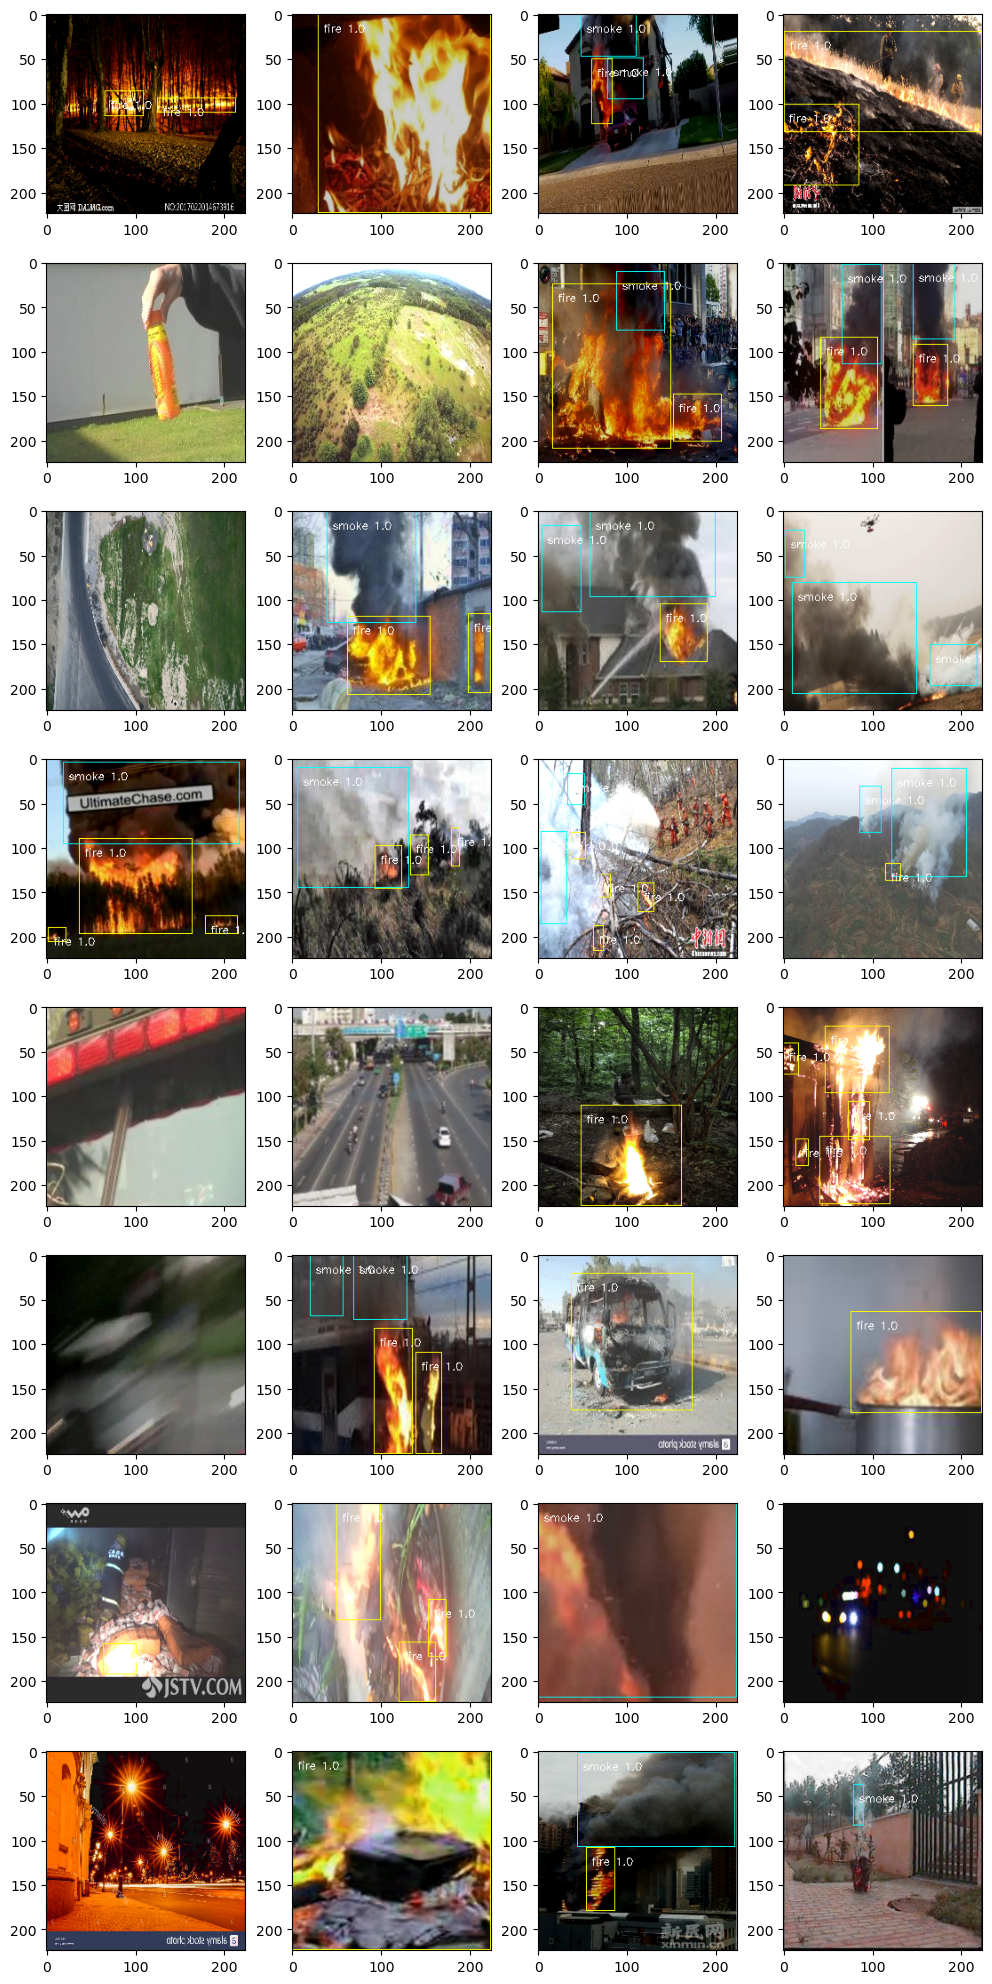

In [16]:
#for i, (img, label_mtx, img_path) in enumerate(view_loader):
for i, (img, label_mtx) in enumerate(view_loader):
    #print(f'Batch id = {i}')

    plt.subplots(8,4, figsize=(10, 20))

    for idx in range(VIEW_BATCH_SIZE):
        #print(f'Index inside batch = {idx}')
        #print(img_path[idx])
        bboxes = get_bboxes_from_label_mtx(label_mtx[idx])
        #print(bboxes)
        img_ds = plot_pytorch(img[idx].permute(1, 2, 0), 
                              VIEW_IMG_W, 
                              VIEW_IMG_H, 
                              bboxes)
        plt.subplot(8, 4, idx+1)
        plt.imshow(img_ds)
        #plt.imshow(img[idx].permute(1, 2, 0))
        
        if (idx == 31):
            break
    #if (idx == 1):
    plt.tight_layout()
    plt.show()
    break

# SqueezeNet Model

In [17]:
class Fire(nn.Module):
    def __init__(self, inplanes: int, squeeze_planes: int, expand1x1_planes: int, expand3x3_planes: int) -> None:
        super().__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes, kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes, kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat(
            [self.expand1x1_activation(self.expand1x1(x)), self.expand3x3_activation(self.expand3x3(x))], 1
        )


class SqueezeNet(nn.Module):
    def __init__(self, B: int, num_classes: int) -> None:
        super().__init__()
        
        self.num_classes = num_classes
        self.B = B
        
        self.features = nn.Sequential(
            # 224x224
            nn.Conv2d(3, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),

            # 111x111
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),

            # 55x55
            Fire(64, 16, 64, 64),
            Fire(128, 16, 64, 64),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),

            # 27x27
            Fire(128, 32, 128, 128),
            Fire(256, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),

            # 13x13
            Fire(256, 48, 192, 192),
            Fire(384, 48, 192, 192),
            Fire(384, 64, 256, 256),
            Fire(512, 64, 256, 256),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        )
        
        self.head = nn.Sequential(
            # 6x6
            #nn.Conv2d(512, 128, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.Conv2d(512, 128, kernel_size=1, stride=1, padding=0),
            #nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            
            #nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0),
            #nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            
            #nn.Conv2d(64, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.Conv2d(64, 16, kernel_size=1, stride=1, padding=0),
            #nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            #nn.Conv2d(16, self.B*5 + self.num_classes, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.Conv2d(16, self.B*5 + self.num_classes, kernel_size=1, stride=1, padding=0),
        )


    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x_out = self.head(x)
        x = x_out.permute(0, 2, 3, 1)
        if self.B == 1:
            class_softmax = torch.softmax(x[..., 5:7], dim=-1)
            x = torch.cat((torch.sigmoid(x[..., 0:5]), class_softmax), dim=-1)  
        else:
            class_softmax = torch.softmax(x[..., 10:12], dim=-1)
            x = torch.cat((torch.sigmoid(x[..., 0:10]), class_softmax), dim=-1)
        return x 

# OPTIM BED

In [18]:
class OPTIM_BED(nn.Module):
    def __init__(self, num_classes, S, B, in_channels=3):
        super(OPTIM_BED, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.S = S
        self.B = B
        
        self.model = self.__create_BED__()

        
    def __create_BED__(self):
        BED_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 224x224
            nn.Conv2d(self.in_channels, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            #nn.Dropout2d(p=0.3),

            # CNNBlock 112x112
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 24, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(24, affine=False),
            nn.ReLU(),
            #nn.Dropout2d(p=0.3),

            # CNNBlock 56x56
            nn.MaxPool2d(kernel_size=2, stride=2),
            # kernel = 1 in github
            nn.Conv2d(24, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            # kernel = 1 in github
            nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 28x28
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 14x14
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            # CNNBlock 7x7
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            
            # CNNBlock Out
            nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            
            nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            
            nn.Conv2d(64, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, self.B*5 + self.num_classes, kernel_size=1, stride=1, padding=0,  bias=False),
            
        )
        return BED_model
        
          

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    # [xc1, yc1, w1, h1, conf1, xc2, yc2, w2, h2, conf2, smoke, fire]
    # [0 ................. 4,    5 ................ 9      10    11 ]
    def forward(self, x):
        x_out = self.model(x)
        x = x_out.permute(0, 2, 3, 1)
        if self.B == 1:
            class_softmax = torch.softmax(x[..., 5:7], dim=-1)
            x = torch.cat((torch.sigmoid(x[..., 0:5]), class_softmax), dim=-1)  
        else:
            class_softmax = torch.softmax(x[..., 10:12], dim=-1)
            x = torch.cat((torch.sigmoid(x[..., 0:10]), class_softmax), dim=-1)
        return x 

# Yolo Loss 2BB

In [19]:
class YoloLossMSE_2BBox(nn.Module):
    '''
    Calculates Yolo V1 loss function, detailed in the paper

    Prediction format [xcell, ycell, w, h, confidence, class_0, class_1]
    Future update to 2 BB: [xcell, ycell, w, h, confidence_A, xcell, ycell, w, h, confidence_B, class_0, class_1]
    '''

    def __init__(self, SX, SY, B, C):
        super(YoloLossMSE_2BBox, self).__init__()
        
        self.mse = nn.MSELoss(reduction="sum")

        self.SX = SX
        self.SY = SY
        self.B = B
        self.C = C

        self.lambda_coord = 5
        self.lambda_noobj = 0.5
        self.lambda_conf = 1.5
              
        self.last_box_xy = 0.0
        self.last_box_wh = 0.0
        self.last_obj = 0.0
        self.last_noobj =0.0
        self.last_class = 0.0

    def forward(self, ground_truth, predictions):

        #predictions = predictions.reshape(-1, self.SY, self.SX, self.B*5 + self.C)
        assert predictions.shape == (BATCH_SIZE, self.SY, self.SX, self.B*5 + self.C) 
        assert ground_truth.shape == (BATCH_SIZE, self.SY, self.SX, 5 + self.C) 
        
        # =========================== #
        #        Exists Box?          #
        # =========================== #
        exists_box = ground_truth[..., 4:5] == 1
        pred_box1 = exists_box*predictions[..., 0:4]
        pred_box2 = exists_box*predictions[..., 5:9]
        target_box = exists_box*ground_truth[..., :4]

        # =========================== #
        #            IOU              #
        # =========================== #
        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou1 = iou_tensor(boxes_preds=pred_box1, 
                   boxes_labels=target_box,
                   box_format="midpoint")
        #print(f'IOU 1\n{iou1}')
        iou2 = iou_tensor(boxes_preds=pred_box2, 
                   boxes_labels=target_box,
                   box_format="midpoint")
        #print(f'IOU 2\n{iou2}')
        ious = torch.cat([iou1, iou2], dim=-1)
        #print(f'IOUs\n{ious}')
        
        iou_maxes, best_boxes = torch.max(ious, keepdim=True, dim=-1)
        pred_boxes = best_boxes*pred_box2[..., :4]+(1-best_boxes)*pred_box1[..., :4]

        # =============== #
        #   Center Loss   #
        # =============== #
        xy_loss = self.mse(pred_boxes[..., :2],
                           target_box[..., :2])
        self.last_box_xy = xy_loss.item()
        #print('\nCenter Loss', center_loss)

        # ====================== #
        #   Width, Height Loss   #
        # ====================== #
        # Use torch.sign to undo torch.abs and preserve gradient sign 
        wh_loss = self.mse(torch.sign(pred_boxes[..., 2:4])*torch.sqrt(torch.abs(pred_boxes[..., 2:4])+1e-6),
                           torch.sqrt(target_box[..., 2:4]))
        #print(f'WH Loss {wh_loss:.6f}')
        self.last_box_wh = wh_loss.item()

        # =================== #
        #   Confidence Loss   #
        # =================== #
        conf_pred_box = exists_box*( best_boxes*predictions[..., 9:10] + (1-best_boxes) * predictions[..., 4:5])
        #print(f'Conf pred boxes \n {conf_pred_box}')
        # conf_loss = self.mse(conf_pred_box,
        #                      iou_maxes)
        conf_loss = self.mse(conf_pred_box,
                             exists_box*ground_truth[..., 4:5])
        #print(f'Conf loss {conf_loss:.6f}')
        self.last_obj = conf_loss.item()

        # ================== #
        #   No Object Loss   #
        # ================== #
        noobj_box1 = self.mse((~exists_box)*predictions[..., 4:5],
                              (~exists_box)*ground_truth[..., 4:5])
        noobj_box2 = self.mse((~exists_box)*predictions[..., 9:10],
                              (~exists_box)*ground_truth[..., 4:5])    
        noobj_loss = noobj_box1 + noobj_box2
        #print(f'No Obj loss {noobj_loss:.6f}')
        self.last_noobj = noobj_loss.item()

        # ======================= #
        #   Classification Loss   #
        # ======================= #
        class_loss = self.mse(exists_box*predictions[..., 10:12],
                              exists_box*ground_truth[..., 5:7]) 
        #print(f'Class Loss {class_loss:.6f}')
        self.last_class = class_loss.item()

        # ============== #
        #   Total Loss   #
        # ============== #
        total_loss = (
            self.lambda_coord*(xy_loss + wh_loss)
            + self.lambda_conf*conf_loss
            + self.lambda_noobj*noobj_loss 
            + class_loss
        )

        return total_loss

    def get_last_losses(self):     
        return (
            self.lambda_coord*self.last_box_xy,
            self.lambda_coord*self.last_box_wh,
            self.lambda_conf*self.last_obj,
            self.lambda_noobj*self.last_noobj,
            self.last_class
            )

# YOLO Loss with CIOU

In [20]:
class YoloLossCIOU_2BBox(nn.Module):
    '''
    Calculates Yolo V1 loss function, detailed in the paper

    Prediction format [xcell, ycell, w, h, confidence, class_0, class_1]
    Future update to 2 BB: [xcell, ycell, w, h, confidence_A, xcell, ycell, w, h, confidence_B, class_0, class_1]
    '''

    def __init__(self, SX, SY, B, C):
        super(YoloLossCIOU_2BBox, self).__init__()
        
        self.mse = nn.MSELoss(reduction="sum")

        self.SX = SX
        self.SY = SY
        self.B = B
        self.C = C

        self.lambda_coord = 5
        self.lambda_noobj = 0.5
        self.lambda_conf = 1.5
        
        self.box_ciou = 0.0
        
        self.last_obj = 0.0
        self.last_noobj =0.0
        self.last_class = 0.0
        
        self.cell2box_mask = self.get_cell2box_mask()
        
    def get_cell2box_mask(self):
        dev = "cuda" if torch.cuda.is_available() else "cpu" 
        cell2box_mask = torch.zeros((SY, SX, 2), device=torch.device(dev)) 
        for i in range(SY):
            for j in range(SX):
                cell2box_mask[i,j,0] = j
                cell2box_mask[i,j,1] = i
        return cell2box_mask   

    def forward(self, ground_truth, predictions):

        #predictions = predictions.reshape(-1, self.SY, self.SX, self.B*5 + self.C)
        assert predictions.shape == (BATCH_SIZE, self.SY, self.SX, self.B*5 + self.C) 
        assert ground_truth.shape == (BATCH_SIZE, self.SY, self.SX, 5 + self.C) 
        
        # =========================== #
        #        Exists Box?          #
        # =========================== #
        exists_box = ground_truth[..., 4:5] == 1
        pred_box1 = exists_box*predictions[..., 0:4]
        pred_box2 = exists_box*predictions[..., 5:9]
        target_box = exists_box*ground_truth[..., :4]

        # =========================== #
        #            IOU              #
        # =========================== #
        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou1 = iou_tensor(boxes_preds=pred_box1, 
                   boxes_labels=target_box,
                   box_format="midpoint")
        #print(f'IOU 1\n{iou1}')
        iou2 = iou_tensor(boxes_preds=pred_box2, 
                   boxes_labels=target_box,
                   box_format="midpoint")
        #print(f'IOU 2\n{iou2}')
        ious = torch.cat([iou1, iou2], dim=-1)
        #print(f'IOUs\n{ious}')
        
        iou_maxes, best_boxes = torch.max(ious, keepdim=True, dim=-1)
        pred_boxes = best_boxes*pred_box2[..., :4]+(1-best_boxes)*pred_box1[..., :4]
        
        # =============== #
        #      CIOU       #
        # =============== # 
        # Convert cells to boxes and concat
        target_cell2box_x = (self.cell2box_mask[..., 0:1] + target_box[..., 0:1]) / self.SX 
        target_cell2box_y = (self.cell2box_mask[..., 1:2] + target_box[..., 1:2]) / self.SY
        pred_cell2box_x = (self.cell2box_mask[..., 0:1] + pred_boxes[..., 0:1]) / self.SX
        pred_cell2box_y = (self.cell2box_mask[..., 1:2] + pred_boxes[..., 1:2]) / self.SY
        
        target_cell2box = torch.concat((target_cell2box_x, target_cell2box_y, target_box[..., 2:4]), dim=-1)
        pred_cell2box = torch.concat((pred_cell2box_x, pred_cell2box_y, pred_boxes[..., 2:4]), dim=-1)
        
        # Convert yolo [x, y, w, h] to [x1, y1, x2, y2]
        target_x1 = ( target_cell2box[..., 0:1] - target_cell2box[..., 2:3] / 2 ).clamp(min=0)
        target_y1 = ( target_cell2box[..., 1:2] - target_cell2box[..., 3:4] / 2 ).clamp(min=0)
        target_x2 = ( target_cell2box[..., 0:1] + target_cell2box[..., 2:3] / 2 ).clamp(max=1)
        target_y2 = ( target_cell2box[..., 1:2] + target_cell2box[..., 3:4] / 2 ).clamp(max=1)
        target_xyxy = torch.concat((target_x1, target_y1, target_x2, target_y2, ground_truth[..., 4:5]), dim=-1)
        # Zeroing all cells with no box, as we summed for cell2box to all cells
        target_xyxy = exists_box * target_xyxy
        
        pred_x1 = ( pred_cell2box[..., 0:1] - pred_cell2box[..., 2:3] / 2 ).clamp(min=0)
        pred_y1 = ( pred_cell2box[..., 1:2] - pred_cell2box[..., 3:4] / 2 ).clamp(min=0)
        pred_x2 = ( pred_cell2box[..., 0:1] + pred_cell2box[..., 2:3] / 2 ).clamp(max=1)
        pred_y2 = ( pred_cell2box[..., 1:2] + pred_cell2box[..., 3:4] / 2 ).clamp(max=1)
        pred_xyxy = torch.concat((pred_x1, pred_y1, pred_x2, pred_y2), dim=-1)
        pred_xyxy = exists_box * pred_xyxy
        
        # Reshape and calculate Loss CIOU
        # For target, we keep confidence, to filter before CIOU
        target_boxes_reshape = target_xyxy.reshape(-1, 5)
        idx_nonzero = target_boxes_reshape[..., 4] == 1
        target_boxes_filter = target_boxes_reshape[idx_nonzero, 0:4]
        
        pred_boxes_reshape = pred_xyxy.reshape(-1, 4)
        pred_boxes_filter = pred_boxes_reshape[idx_nonzero, 0:4]
        #box_ciou_loss = complete_box_iou_loss(target_boxes_filter, pred_boxes_filter, reduction="sum")
        box_ciou_loss = distance_box_iou_loss(target_boxes_filter, pred_boxes_filter, reduction="sum")
        if (np.isnan(box_ciou_loss.item())):
            # print(f'Target boxes -> NaN\n{target_boxes_filter}')
            # print(f'Pred boxes -> NaN\n{pred_boxes_filter}')
            raise SystemExit("Stop right there!")
        self.box_ciou = box_ciou_loss.item()

        # =================== #
        #   Confidence Loss   #
        # =================== #
        conf_pred_box = exists_box*( best_boxes*predictions[..., 9:10] + (1-best_boxes) * predictions[..., 4:5])
        #print(f'Conf pred boxes \n {conf_pred_box}')
        # conf_loss = self.mse(conf_pred_box,
        #                      iou_maxes)
        conf_loss = self.mse(conf_pred_box,
                             exists_box*ground_truth[..., 4:5])
        #print(f'Conf loss {conf_loss:.6f}')
        self.last_obj = conf_loss.item()

        # ================== #
        #   No Object Loss   #
        # ================== #
        noobj_box1 = self.mse((~exists_box)*predictions[..., 4:5],
                              (~exists_box)*ground_truth[..., 4:5])
        noobj_box2 = self.mse((~exists_box)*predictions[..., 9:10],
                              (~exists_box)*ground_truth[..., 4:5])    
        noobj_loss = noobj_box1 + noobj_box2
        #print(f'No Obj loss {noobj_loss:.6f}')
        self.last_noobj = noobj_loss.item()

        # ======================= #
        #   Classification Loss   #
        # ======================= #
        class_loss = self.mse(exists_box*predictions[..., 10:12],
                              exists_box*ground_truth[..., 5:7]) 
        #print(f'Class Loss {class_loss:.6f}')
        self.last_class = class_loss.item()

        # ============== #
        #   Total Loss   #
        # ============== #
        total_loss = (
            self.lambda_coord*box_ciou_loss
            + self.lambda_conf*conf_loss
            + self.lambda_noobj*noobj_loss 
            + class_loss
        )

        return total_loss

    def get_last_losses(self):     
        return (
            self.lambda_coord*self.box_ciou,
            self.lambda_conf*self.last_obj,
            self.lambda_noobj*self.last_noobj,
            self.last_class
            )

# Train Loop Function

In [21]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, loss_l1_lambda, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
    logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_mean_loss = []
    mean_box_loss = []
    mean_confidence_loss = []
    mean_noobj_loss = []
    mean_class_loss = []

    for batch_idx, (x, y) in enumerate(loop):
#     for batch_idx, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)
#         loss = loss_fn.forward(ground_truth=y, 
#                        predictions=out)

        l1_lambda = loss_l1_lambda  # hyperparameter for L1 regularization
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        train_loss = train_loss + l1_lambda * l1_norm
        
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        # update progress bar
        #loop.set_postfix(loss=loss.item())
        #print(f'Partial Train Loss: {loss.item()}')

        # MSE Loss
        xy_loss, wh_loss, obj_loss, noobj_loss, class_loss = loss_fn.get_last_losses()
        # Appending each loss
        train_mean_loss.append(train_loss.item())
        box_loss = xy_loss + wh_loss
        mean_box_loss.append(box_loss)
        mean_confidence_loss.append(obj_loss)
        mean_noobj_loss.append(noobj_loss)
        mean_class_loss.append(class_loss)
        
        # CIOU Loss
        # ciou_loss, obj_loss, noobj_loss, class_loss = loss_fn.get_last_losses()
        # #print(f'CIOU Loss of batch_idx {batch_idx} = {ciou_loss}')
        # # Appending each loss
        # train_mean_loss.append(train_loss.item())
        # mean_box_loss.append(ciou_loss)
        # mean_confidence_loss.append(obj_loss)
        # mean_noobj_loss.append(noobj_loss)
        # mean_class_loss.append(class_loss)

    train_mean_loss_out = sum(train_mean_loss)/len(train_mean_loss)
    #print("\nTRAIN losses")
    logger.info("\nTRAIN losses")
    mean_box_loss_out = sum(mean_box_loss)/len(mean_box_loss)
    mean_confidence_loss_out = sum(mean_confidence_loss)/len(mean_confidence_loss)
    mean_noobj_loss_out = sum(mean_noobj_loss)/len(mean_noobj_loss)
    mean_class_loss_out = sum(mean_class_loss)/len(mean_class_loss)  

    print("Total Loss".ljust(12) + "|" + 
          "Box Loss".ljust(12) + "|" + 
          "Conf Loss".ljust(12) + "|" + 
          "No Obj Loss".ljust(12) + "|" + 
          "Class Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_box_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_confidence_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_noobj_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_class_loss_out:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
                  "Box Loss".ljust(12) + "|" + 
                  "Conf Loss".ljust(12) + "|" + 
                  "No Obj Loss".ljust(12) + "|" + 
                  "Class Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
                  "------------".ljust(12) + " " + 
                  "------------".ljust(12) + " " + 
                  "------------".ljust(12) + " " + 
                  "------------".ljust(12))
    logger.info(f'{train_mean_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_box_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_confidence_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_noobj_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_class_loss_out:.3f}'.ljust(12))
    
    return (train_mean_loss_out, 
            mean_box_loss_out, 
            mean_confidence_loss_out, 
            mean_noobj_loss_out, 
            mean_class_loss_out)
    
#     return train_mean_loss_out


# Validation Loop Function

In [22]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_mean_loss = []
    mean_box_loss = []
    mean_confidence_loss = []
    mean_noobj_loss = []
    mean_class_loss = []

    for batch_idx, (x, y) in enumerate(loop):
#     for batch_idx, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)
#         loss = loss_fn.forward(ground_truth=y, 
#                                predictions=out)
        
        # MSE Loss
        xy_loss, wh_loss, obj_loss, noobj_loss, class_loss = loss_fn.get_last_losses()
        # Appending each loss
        val_mean_loss.append(val_loss.item())
        box_loss = xy_loss + wh_loss
        mean_box_loss.append(box_loss)
        mean_confidence_loss.append(obj_loss)
        mean_noobj_loss.append(noobj_loss)
        mean_class_loss.append(class_loss)
        
        # CIOU Loss
        # ciou_loss, obj_loss, noobj_loss, class_loss = loss_fn.get_last_losses()
        # # Appending each loss
        # val_mean_loss.append(val_loss.item())
        # mean_box_loss.append(ciou_loss)
        # mean_confidence_loss.append(obj_loss)
        # mean_noobj_loss.append(noobj_loss)
        # mean_class_loss.append(class_loss)
        
        # update progress bar
        #loop.set_postfix(loss=loss.item())

    val_mean_loss_out = sum(val_mean_loss)/len(val_mean_loss)
    #print("\nVAL losses")
    logger.info("\nVAL losses")
#     print(f"Mean total loss was {val_mean_loss_out:.3f}") # TQDM prints last batch loss
    mean_box_loss_out = sum(mean_box_loss)/len(mean_box_loss)
    mean_confidence_loss_out = sum(mean_confidence_loss)/len(mean_confidence_loss)
    mean_noobj_loss_out = sum(mean_noobj_loss)/len(mean_noobj_loss)
    mean_class_loss_out = sum(mean_class_loss)/len(mean_class_loss)  
#     print(f"Mean box loss was {mean_box_loss_out:.3f}") 
#     print(f"Mean confidence loss was {mean_confidence_loss_out:.3f}") 
#     print(f"Mean noobj loss was {mean_noobj_loss_out:.3f}") 
#     print(f"Mean class loss was {mean_class_loss_out:.3f}") 

    print("Total Loss".ljust(12) + "|" + 
          "Box Loss".ljust(12) + "|" + 
          "Conf Loss".ljust(12) + "|" + 
          "No Obj Loss".ljust(12) + "|" + 
          "Class Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_box_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_confidence_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_noobj_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_class_loss_out:.3f}'.ljust(12))

    logger.info("Total Loss".ljust(12) + "|" + 
                  "Box Loss".ljust(12) + "|" + 
                  "Conf Loss".ljust(12) + "|" + 
                  "No Obj Loss".ljust(12) + "|" + 
                  "Class Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
                  "------------".ljust(12) + " " + 
                  "------------".ljust(12) + " " + 
                  "------------".ljust(12) + " " + 
                  "------------".ljust(12))
    logger.info(f'{val_mean_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_box_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_confidence_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_noobj_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_class_loss_out:.3f}'.ljust(12))
    
    return (val_mean_loss_out, 
            mean_box_loss_out, 
            mean_confidence_loss_out, 
            mean_noobj_loss_out, 
            mean_class_loss_out)
    
#     return val_loss_out

# Hyperparameters and Config

In [23]:
''' ============================
    Hyperparameters and More
============================ '''

LEARNING_RATE = 5e-4
#LEARNING_RATE = 1e-1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64 
WEIGHT_DECAY = 1e-4
#WEIGHT_DECAY = 0
EPOCHS = 90
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = log_path + "squeeze_best_2BB_mAP.pt"

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
EVAL_IMG_DIR = val_imgs
EVAL_LABEL_DIR = val_labels

TRAIN_MAX_OBJ = 20
TEST_MAX_OBJ = 3
TRAIN_NUM_IMGS = None
TEST_NUM_IMGS = None

LOSS_FN = "MSE"
L1_LAMBDA = 0.001

LOG_FILE = "log_file.xlsx"

IOU_mAP_THRES = 0.5
IOU_NMS_THRES = 0.3
THRESHOLD = 0.2

''' ============================
    Configuration
============================ '''
IMG_W = IMG_DIM['W']
IMG_H = IMG_DIM['H']

CELL_SIZE_X = 1/SX
CELL_SIZE_Y = 1/SY


''' ============================
    Metrics
============================ '''
# mAP output
## Train
train_mAP = []
train_class_AP = []
train_class_precision = []
train_class_recall = []
## Val
val_mAP = []
val_class_AP = []
val_class_precision = []
val_class_recall = []

# Loss output
## Train
train_total_loss = []
train_box_loss = []
train_confidence_loss = []
train_noobj_loss = []
train_class_loss = []
## Val
val_total_loss = []
val_box_loss = []
val_confidence_loss = []
val_noobj_loss = []
val_class_loss = []

epochs_plot = []

# Main Function

In [24]:
def main():

    ''' ============================
        Print Config Values
    ============================ '''
    print(f'Device: {DEVICE}')
    print(f'Learning Rate: {LEARNING_RATE}')
    print(f'Weight Decay: {WEIGHT_DECAY}')
    print(f'Batch Size: {BATCH_SIZE}')
    print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    print(f'W: {IMG_W}\nH: {IMG_H}')
    print(f'SX: {SX}\nSY: {SY}\nB: {B}\nC: {C}')
    #print(f'Cell size:\n\tx = {CELL_SIZE_X}\n\ty = {CELL_SIZE_Y}')
    print(f'\nConfidence Threshold: {THRESHOLD}')
    print(f'IOU mAP Threshold: {IOU_mAP_THRES}')
    print(f'IOU NMS Threshold: {IOU_NMS_THRES}\n')
    print(f'Max Train Obj per image: {TRAIN_MAX_OBJ}')
    print(f'Max Test Obj per image: {TEST_MAX_OBJ}')
    print(f'Train num images: {TRAIN_NUM_IMGS}')
    print(f'Test num images: {TEST_NUM_IMGS}\n')
    
    logger.info(f'Device: {DEVICE}')
    logger.info(f'Learning Rate: {LEARNING_RATE}')
    logger.info(f'Weight Decay: {WEIGHT_DECAY}')
    logger.info(f'Batch Size: {BATCH_SIZE}')
    logger.info(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    logger.info(f'W: {IMG_W}\nH: {IMG_H}')
    logger.info(f'SX: {SX}\nSY: {SY}\nB: {B}\nC: {C}')
    logger.info(f'\nConfidence Threshold: {THRESHOLD}')
    logger.info(f'IOU mAP Threshold: {IOU_mAP_THRES}')
    logger.info(f'IOU NMS Threshold: {IOU_NMS_THRES}\n')
    logger.info(f'Max Train Obj per image: {TRAIN_MAX_OBJ}')
    logger.info(f'Max Test Obj per image: {TEST_MAX_OBJ}\n')
    logger.info(f'Train num images: {TRAIN_NUM_IMGS}')
    logger.info(f'Test num images: {TEST_NUM_IMGS}\n')
    #logger.info(f'Cell size:\n\tx = {CELL_SIZE_X}\n\ty = {CELL_SIZE_Y}')

    ''' ============================
        Cell to Box Mask
    ============================ '''
    cell2box_mask = torch.zeros((SY, SX, 2))
    for i in range(SY):
        for j in range(SX):
            cell2box_mask[i,j,0] = j
            cell2box_mask[i,j,1] = i    
#     print(cell2box_mask)
#     print("\n")

    ''' ======================================
        SETUP: Model, Loss, Dataset, Loader
    ====================================== '''
    if IMG_W == 88:
        print("Using Tinyssimo 88x88")
        logger.info("Using Tinyssimo 88x88")
        #model_tynss = Tinyssimo_fixed_88x88(num_classes=C).to(DEVICE)
        model_tynss = Tinyssimo_fixed_88x88_BatchNorm(num_classes=C).to(DEVICE)
        #model_tynss = Tinyssimo_fixed_88x88_NANO(num_classes=C).to(DEVICE)
    elif IMG_W == 448:
        print("Using Tinyssimo 448x448")
        logger.info("Using Tinyssimo 448x448")
        model_tynss = Tinyssimo_fixed_448x448(num_classes=C).to(DEVICE)
    elif IMG_W == 224:
        print("Using SqueezeNet 224x224")
        logger.info("Using SqueezeNet 224x224")
        squeeze_model = SqueezeNet(B = B, num_classes = C).to(DEVICE)
    else:
        print("Using Tinyssimo 160x120")
        logger.info("Using Tinyssimo 160x120")
        model_tynss = Tinyssimo_fixed_160x120(num_classes=C).to(DEVICE)
    
    #model_tynss._initialize_weights() # Postponed after Load True/False 

    # Check model shape
    in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
    in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
    out_test = squeeze_model(in_rand)
    print(f'Model shape is {out_test.shape}')
    print(f'Squeeze Model Arquitecture\n{squeeze_model}')
    logger.info(f'Model shape is {out_test.shape}')
    logger.info(f'Squeeze Model Arquitecture\n{squeeze_model}')   
    
    optimizer = optim.Adam(squeeze_model.parameters(), 
                           lr=LEARNING_RATE, 
                           weight_decay=WEIGHT_DECAY)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min',
                                                     factor=0.8, 
                                                     patience=2, 
                                                     threshold=0.1, 
                                                     threshold_mode='abs',
                                                     min_lr=1e-6)
    
#     optimizer = torch.optim.SGD(model_tynss.parameters(), 
#                                 lr=LEARNING_RATE,
#                                 momentum=0.9, 
#                                 weight_decay=WEIGHT_DECAY, 
#                                 nesterov=True)
    
    n_trainable = sum(p.numel() for p in squeeze_model.parameters() if p.requires_grad)
    print(f'\nTrainable parameters = {n_trainable}')
    logger.info(f'\nTrainable parameters = {n_trainable}')

    n_params = parameters_to_vector(squeeze_model.parameters()).numel()
    print(f'Total parameters = {n_params}\n')
    logger.info(f'Total parameters = {n_params}\n')
    
    if B == 1:
        print(f'Using YoloLossMSE')
        logger.info(f'Using YoloLossMSE')
        loss_fn = YoloLossMSE(SX=SX, 
                              SY=SY, 
                              B=B, 
                              C=C)
    elif B == 2:
        if LOSS_FN == "MSE":
            print(f'Using YoloLossMSE_2BBox')
            logger.info(f'Using YoloLossMSE_2BBox')
            loss_fn = YoloLossMSE_2BBox(SX=SX, 
                                        SY=SY, 
                                        B=B, 
                                        C=C)
        elif LOSS_FN == "DIOU":
            print(f'Using YoloLossDIOU_2BBox')
            logger.info(f'Using YoloLossDIOU_2BBox')
            loss_fn =YoloLossCIOU_2BBox(SX=SX, 
                                        SY=SY, 
                                        B=B, 
                                        C=C)
        else:
            raise SystemExit("Wrong Loss Function")
        print(f'L1 lambda: {L1_LAMBDA}')
        logger.info(f'L1 lambda: {L1_LAMBDA}')
    else:
        print(f"Wrong B bounding boxes configuration: {B}")
        logger.info(f"Wrong B bounding boxes configuration: {B}")
        raise SystemExit("Wrong B bounding boxes configuration")

    train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        # If boxes are to close, it can remove some because they fall inside same cell
        A.RandomSizedBBoxSafeCrop(height=int(1.4*IMG_H),
                                  width= int(1.4*IMG_W),
                                  erosion_rate=0.3,
                                  p=0.3),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
        ], p=0.9),
            # Shifting, scaling and rotation could dive 2 bbox inside same grid...
            #A.ShiftScaleRotate(rotate_limit=10, p=0.2),
        A.Resize(IMG_H, IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
        ToTensorV2(p=1),
    ], bbox_params=A.BboxParams(format='yolo', 
                                min_area=16*16, 
                                min_visibility=0.1, 
                                label_fields=['class_labels']))
    # TRAIN
    print("\nTRAIN DFIRE dataset")
    logger.info("\nTRAIN DFIRE dataset")
    train_dataset = DFireDataset(img_h = IMG_H,
                                 img_w = IMG_W,
                                 img_dir = TRAIN_IMG_DIR,
                                 label_dir = TRAIN_LABEL_DIR,
                                 num_imgs = TRAIN_NUM_IMGS,
                                 SX = SX,
                                 SY = SY,
                                 C = C,
                                 max_obj = TRAIN_MAX_OBJ,
                                 transform=train_transform)
    
    print("TRAIN DFS dataset")
    logger.info("TRAIN DFS dataset")
    train_dfs_dataset = DFSDataset(img_h = IMG_H,
                                   img_w = IMG_W,
                                   img_dir = dfs_images_dir,
                                   labels_list = dfs_train_list,
                                   SX = SX,
                                   SY = SY,
                                   C = C,
                                   max_obj = TRAIN_MAX_OBJ,
                                   transform=train_transform)

    print("Concatenate Train DFire and DFS datasets")
    logger.info("Concatenate Train DFire and DFS datasets")
    full_train_ds = torch.utils.data.ConcatDataset((train_dataset, train_dfs_dataset))
    print(f'Train dataset len: {len(full_train_ds)}')
    logger.info(f'Train dataset len: {len(full_train_ds)}')

    
    # VALIDATION
    val_transform = A.Compose([
        A.Resize(IMG_H, IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
        ToTensorV2(p=1),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
    
    print("\nTEST DFire dataset")
    logger.info("\nTEST DFire dataset")
    eval_dataset = DFireDataset(img_h = IMG_H,
                                img_w = IMG_W,
                                img_dir = EVAL_IMG_DIR,
                                label_dir = EVAL_LABEL_DIR,
                                num_imgs = TEST_NUM_IMGS,
                                SX = SX,
                                SY = SY,
                                C = C,
                                max_obj = TEST_MAX_OBJ,
                                transform=val_transform)
    print("TEST DFS dataset")
    logger.info("TEST DFS dataset")
    test_dfs_dataset = DFSDataset(img_h = IMG_H,
                                  img_w = IMG_W,
                                  img_dir = dfs_images_dir,
                                  labels_list = dfs_test_list,
                                  SX = SX,
                                  SY = SY,
                                  C = C,
                                  max_obj = TEST_MAX_OBJ,
                                  transform=val_transform)
    
    print("Concatenate Test DFire and DFS datasets")
    logger.info("Concatenate Test DFire and DFS datasets")
    full_test_ds = torch.utils.data.ConcatDataset((eval_dataset, test_dfs_dataset))
    print(f'Test dataset len: {len(full_test_ds)}')
    logger.info(f'Test dataset len: {len(full_test_ds)}')
    
    
    # LOADERS
    train_loader = DataLoader(dataset=full_train_ds,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              pin_memory=PIN_MEMORY,
                              shuffle=True,
                              drop_last=True)

    eval_loader = DataLoader(dataset=full_test_ds,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             pin_memory=PIN_MEMORY,
                             shuffle=False,
                             drop_last=True)


    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_mAP = -1

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = 0

    if LOAD_MODEL == False:
        print("Initializing Weights")
        logger.info("Initializing Weights")
        squeeze_model.init_weights()
    else:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        squeeze_model.load_state_dict(checkpoint['model_state_dict'])
        squeeze_model.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    #for epoch in range(EPOCHS):
    for epoch in range(start_epoch, EPOCHS):

        print(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        
        # TRAINING
        t_loss, b_loss, conf_loss, n_loss, cls_loss = train_fn(loader=train_loader, 
                                                               model=squeeze_model, 
                                                               optimizer=optimizer, 
                                                               loss_fn=loss_fn,
                                                               loss_l1_lambda=L1_LAMBDA,
                                                               device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(t_loss)
        train_box_loss.append(b_loss)
        train_confidence_loss.append(conf_loss)
        train_noobj_loss.append(n_loss)
        train_class_loss.append(cls_loss)
        
        ##### NO LOGS, ONLY TOTAL LOSS
#         t_loss = train_fn(loader=train_loader, 
#                           model=model_tynss, 
#                           optimizer=optimizer, 
#                           loss_fn=loss_fn,
#                           device=DEVICE)
#         # Appending Train Losses
#         train_total_loss.append(t_loss)


        # TRAIN MEAN AVERAGE PRECISION
        if ( (epoch+1) % 15 ) == 0:
            pred_boxes, target_boxes = get_bboxes(loader=train_loader, 
                                                  model=squeeze_model,
                                                  SX=SX,
                                                  SY=SY,
                                                  B=B,
                                                  C=C,
                                                  mask=cell2box_mask,
                                                  iou_threshold=IOU_NMS_THRES, 
                                                  threshold=THRESHOLD,
                                                  device=DEVICE,
                                                  box_format="midpoint")

            mean_avg_prec, avg_prec, cls_prec, cls_rec = mAP(pred_boxes=pred_boxes, 
                                                             true_boxes=target_boxes, 
                                                             iou_threshold=IOU_mAP_THRES, 
                                                             box_format="midpoint",
                                                             num_classes=C)

            train_mAP.append(mean_avg_prec)
            train_class_AP.append(avg_prec)   
            train_class_precision.append(cls_prec)
            train_class_recall.append(cls_rec)
            print(f"\nTrain mAP: {mean_avg_prec:.3f}")
            logger.info(f"\nTrain mAP: {mean_avg_prec:.3f}")
        
        # VALIDATING
        with torch.no_grad():
            v_loss, b_loss, conf_loss, n_loss, cls_loss = eval_fn(loader=eval_loader, 
                                                                  model=squeeze_model,                         
                                                                  loss_fn=loss_fn,
                                                                  device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(v_loss)
            val_box_loss.append(b_loss)
            val_confidence_loss.append(conf_loss)
            val_noobj_loss.append(n_loss)
            val_class_loss.append(cls_loss)
            
            scheduler.step(v_loss)
            
            ##### NO LOGS, ONLY TOTAL LOSS
#             v_loss = eval_fn(loader=eval_loader, 
#                              model=model_tynss,                         
#                              loss_fn=loss_fn,
#                              device=DEVICE)
#             # Appending Validation Losses
#             val_total_loss.append(v_loss)

            # VALIDATION MEAN AVERAGE PRECISION
            if ( (epoch+1) % 5 ) == 0:
                pred_boxes, target_boxes = get_bboxes(loader=eval_loader, 
                                                      model=squeeze_model,
                                                      SX=SX,
                                                      SY=SY,
                                                      B=B,
                                                      C=C,
                                                      mask=cell2box_mask,
                                                      iou_threshold=IOU_NMS_THRES, 
                                                      threshold=THRESHOLD,
                                                      device=DEVICE,
                                                      box_format="midpoint")

                mean_avg_prec, avg_prec, cls_prec, cls_rec = mAP(pred_boxes=pred_boxes, 
                                                                 true_boxes=target_boxes, 
                                                                 iou_threshold=IOU_mAP_THRES, 
                                                                 box_format="midpoint",
                                                                 num_classes=C)

                val_mAP.append(mean_avg_prec)
                val_class_AP.append(avg_prec)   
                val_class_precision.append(cls_prec)
                val_class_recall.append(cls_rec)
                print(f"\nValidation mAP: {mean_avg_prec:.3f}")
                logger.info(f"\nValidation mAP: {mean_avg_prec:.3f}")

                epochs_plot.append(epoch)
                plt.plot(epochs_plot, val_mAP, label="Val mAP")
                plt.title("Val mAP:@.50")
                plt.ylim([0,1])
                plt.xlabel("Epochs")
                plt.ylabel("mAP:@.50")
                plt.legend()
                plt.grid()
                plt.savefig(log_path + "Temp_bed_mAP.png")
                plt.close()

                if best_mAP < mean_avg_prec:
                    best_mAP = mean_avg_prec
                    print(f"\nSaving model with new best val mAP: {best_mAP:.3f}")
                    logger.info(f"\nSaving model with new best val mAP: {best_mAP:.3f}") 
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': squeeze_model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict()}, log_path + 'squeeze_best_2BB_mAP.pt') 

        if ( (epoch+1) % 5 ) == 0:
            torch.save(squeeze_model.state_dict(), log_path + 'squeeze_2BB_5epoch.pt')
            
        if best_valid_loss > v_loss:
            best_valid_loss = v_loss
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save(squeeze_model.state_dict(), log_path + 'best_2BB.pt')     
        
    logger.info('Saving last model')   
    torch.save(squeeze_model.state_dict(), log_path + 'last_2BB.pt') 
    
#     save_log(epochs=EPOCHS, 
#              train_total_loss=train_total_loss,
#              train_box_loss=train_box_loss,
#              train_class_loss=train_class_loss,
#              train_confidence_loss=train_confidence_loss,
#              train_noobj_loss=train_noobj_loss,
#              train_mAP=train_mAP,
#              train_class_AP=train_class_AP,
#              train_class_precision=train_class_precision,
#              train_class_recall=train_class_recall,
#              val_total_loss=val_total_loss,
#              val_box_loss=val_box_loss,
#              val_class_loss=val_class_loss,
#              val_confidence_loss=val_confidence_loss,
#              val_noobj_loss=val_noobj_loss,
#              val_mAP=val_mAP,
#              val_class_AP=val_class_AP,
#              val_class_precision=val_class_precision,
#              val_class_recall=val_class_recall,
#              log_file_dst=LOG_FILE)

    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')

# Main Execute

In [25]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    #print(torch.cuda.is_available())
    main()

Starting script

Device: cuda
Learning Rate: 0.0005
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)
W: 224
H: 224
SX: 6
SY: 6
B: 2
C: 2

Confidence Threshold: 0.2
IOU mAP Threshold: 0.5
IOU NMS Threshold: 0.3

Max Train Obj per image: 20
Max Test Obj per image: 3
Train num images: None
Test num images: None

Using SqueezeNet 224x224
Model shape is torch.Size([4, 6, 6, 12])
Squeeze Model Arquitecture
SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)


Training:   0%|          | 0/355 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Training: 100%|██████████| 355/355 [02:10<00:00,  2.73it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
241.915     |83.318      |77.789      |20.182      |18.828      



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.62it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
136.205     |56.380      |63.714      |8.098       |8.013       

Saving model with new best validation loss: 136.205

=== EPOCH 1/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 355/355 [02:09<00:00,  2.73it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
194.069     |65.166      |72.857      |12.525      |10.975      



Validating: 100%|██████████| 82/82 [00:24<00:00,  3.30it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
126.409     |50.190      |57.700      |11.137      |7.382       

Saving model with new best validation loss: 126.409

=== EPOCH 2/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 355/355 [02:08<00:00,  2.75it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
180.607     |59.727      |69.889      |12.516      |9.623       



Validating: 100%|██████████| 82/82 [00:21<00:00,  3.89it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
124.260     |48.244      |52.127      |16.661      |7.227       

Saving model with new best validation loss: 124.260

=== EPOCH 3/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 355/355 [02:11<00:00,  2.70it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
172.401     |56.423      |67.586      |13.021      |8.868       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.68it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
121.314     |46.499      |50.177      |17.790      |6.848       

Saving model with new best validation loss: 121.314

=== EPOCH 4/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 355/355 [02:08<00:00,  2.76it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
166.948     |54.484      |65.990      |13.270      |8.507       



Validating: 100%|██████████| 82/82 [00:21<00:00,  3.82it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
114.737     |42.545      |53.762      |12.466      |5.965       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]



Validation mAP: 0.040

Saving model with new best val mAP: 0.040

Saving model with new best validation loss: 114.737

=== EPOCH 5/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 355/355 [02:13<00:00,  2.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
162.615     |52.944      |65.203      |13.065      |8.038       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
114.910     |42.700      |55.341      |10.002      |6.868       

=== EPOCH 6/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 355/355 [02:10<00:00,  2.72it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
158.465     |51.396      |63.888      |13.214      |7.699       



Validating: 100%|██████████| 82/82 [00:24<00:00,  3.39it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
108.460     |39.543      |52.228      |11.334      |5.355       

Saving model with new best validation loss: 108.460

=== EPOCH 7/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 355/355 [02:12<00:00,  2.68it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
155.189     |49.927      |63.020      |13.475      |7.424       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.62it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
107.281     |38.196      |50.762      |12.825      |5.498       

Saving model with new best validation loss: 107.281

=== EPOCH 8/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 355/355 [02:14<00:00,  2.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
152.620     |48.935      |62.391      |13.630      |7.049       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.61it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
109.798     |38.867      |55.947      |7.731       |7.253       

=== EPOCH 9/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 355/355 [03:09<00:00,  1.88it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
150.769     |48.618      |61.571      |13.440      |7.119       



Validating: 100%|██████████| 82/82 [00:41<00:00,  1.99it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
108.132     |38.767      |46.765      |16.834      |5.765       


mAP:@.5: 100%|██████████| 2/2 [00:04<00:00,  2.35s/it]



Validation mAP: 0.094

Saving model with new best val mAP: 0.094

=== EPOCH 10/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 355/355 [03:22<00:00,  1.76it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
147.852     |47.472      |60.393      |13.730      |6.805       



Validating: 100%|██████████| 82/82 [00:40<00:00,  2.04it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
106.785     |37.693      |57.555      |6.234       |5.303       

Saving model with new best validation loss: 106.785

=== EPOCH 11/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 355/355 [03:51<00:00,  1.54it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
145.688     |46.662      |59.860      |13.658      |6.553       



Validating: 100%|██████████| 82/82 [00:40<00:00,  2.02it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.207     |35.938      |49.545      |11.995      |4.728       

Saving model with new best validation loss: 102.207

=== EPOCH 12/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 355/355 [03:24<00:00,  1.74it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
144.825     |46.205      |59.248      |14.077      |6.696       



Validating: 100%|██████████| 82/82 [00:39<00:00,  2.06it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
100.735     |36.055      |47.231      |12.784      |4.665       

Saving model with new best validation loss: 100.735

=== EPOCH 13/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 355/355 [03:31<00:00,  1.68it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
143.174     |45.591      |58.922      |13.947      |6.485       



Validating: 100%|██████████| 82/82 [00:25<00:00,  3.17it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.446     |36.397      |48.084      |12.364      |5.600       

=== EPOCH 14/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 355/355 [02:10<00:00,  2.73it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
141.676     |44.589      |58.714      |14.049      |6.414       



mAP:@.5: 100%|██████████| 2/2 [00:37<00:00, 18.80s/it]



Train mAP: 0.161


Validating: 100%|██████████| 82/82 [00:22<00:00,  3.57it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
100.805     |35.512      |51.413      |9.092       |4.787       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]



Validation mAP: 0.161

Saving model with new best val mAP: 0.161

=== EPOCH 15/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 355/355 [02:11<00:00,  2.70it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
140.534     |44.409      |57.990      |14.170      |6.323       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.58it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
101.493     |36.559      |46.060      |13.559      |5.315       

=== EPOCH 16/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 355/355 [02:17<00:00,  2.59it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
138.044     |43.232      |57.175      |14.293      |5.969       



Validating: 100%|██████████| 82/82 [00:24<00:00,  3.38it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
99.228      |35.364      |47.480      |11.592      |4.792       

Saving model with new best validation loss: 99.228

=== EPOCH 17/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 355/355 [02:14<00:00,  2.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
136.731     |42.620      |56.661      |14.445      |5.885       



Validating: 100%|██████████| 82/82 [00:25<00:00,  3.21it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
97.920      |34.444      |50.508      |8.403       |4.564       

Saving model with new best validation loss: 97.920

=== EPOCH 18/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 355/355 [02:11<00:00,  2.69it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
136.146     |42.428      |56.412      |14.361      |5.966       



Validating: 100%|██████████| 82/82 [00:21<00:00,  3.80it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
100.387     |35.663      |49.206      |10.148      |5.369       

=== EPOCH 19/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 355/355 [02:08<00:00,  2.76it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
134.910     |41.654      |55.707      |14.698      |5.998       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.60it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
96.578      |32.997      |47.888      |10.162      |5.532       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]



Validation mAP: 0.210

Saving model with new best val mAP: 0.210

Saving model with new best validation loss: 96.578

=== EPOCH 20/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 355/355 [02:11<00:00,  2.70it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
133.740     |41.278      |55.441      |14.493      |5.830       



Validating: 100%|██████████| 82/82 [00:23<00:00,  3.52it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
94.798      |32.549      |46.954      |10.868      |4.426       

Saving model with new best validation loss: 94.798

=== EPOCH 21/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 355/355 [02:13<00:00,  2.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
132.507     |40.756      |54.920      |14.593      |5.699       



Validating: 100%|██████████| 82/82 [00:21<00:00,  3.78it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
94.785      |32.094      |47.677      |10.278      |4.737       

Saving model with new best validation loss: 94.785

=== EPOCH 22/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 355/355 [02:11<00:00,  2.71it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
132.399     |40.783      |54.715      |14.713      |5.678       



Validating: 100%|██████████| 82/82 [00:21<00:00,  3.73it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
94.295      |32.221      |44.569      |12.674      |4.831       

Saving model with new best validation loss: 94.295

=== EPOCH 23/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 355/355 [02:10<00:00,  2.73it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
131.604     |40.253      |54.643      |14.803      |5.556       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.58it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
94.270      |32.024      |43.429      |14.286      |4.532       

Saving model with new best validation loss: 94.270

=== EPOCH 24/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 355/355 [02:10<00:00,  2.73it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
130.402     |39.861      |54.024      |14.773      |5.562       



Validating: 100%|██████████| 82/82 [00:26<00:00,  3.06it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
94.956      |32.365      |48.633      |9.291       |4.668       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]



Validation mAP: 0.181

=== EPOCH 25/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 355/355 [02:12<00:00,  2.68it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
130.054     |39.828      |53.833      |14.845      |5.470       



Validating: 100%|██████████| 82/82 [00:25<00:00,  3.18it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
93.903      |32.283      |44.526      |12.292      |4.803       

Saving model with new best validation loss: 93.903

=== EPOCH 26/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 355/355 [02:10<00:00,  2.71it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
129.851     |39.810      |53.627      |14.818      |5.554       



Validating: 100%|██████████| 82/82 [00:21<00:00,  3.86it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
92.844      |31.781      |44.773      |11.934      |4.355       

Saving model with new best validation loss: 92.844

=== EPOCH 27/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 355/355 [02:08<00:00,  2.76it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
128.087     |38.983      |52.962      |14.972      |5.261       



Validating: 100%|██████████| 82/82 [00:21<00:00,  3.76it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
94.008      |31.557      |42.593      |14.161      |5.697       

=== EPOCH 28/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 355/355 [02:08<00:00,  2.77it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
128.269     |39.071      |53.268      |14.796      |5.302       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.72it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
93.842      |31.663      |39.877      |16.977      |5.325       

=== EPOCH 29/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 355/355 [02:08<00:00,  2.77it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
127.502     |39.026      |52.535      |14.935      |5.260       



mAP:@.5: 100%|██████████| 2/2 [00:48<00:00, 24.37s/it]



Train mAP: 0.182


Validating: 100%|██████████| 82/82 [00:21<00:00,  3.78it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
92.357      |31.049      |42.460      |14.470      |4.378       


mAP:@.5: 100%|██████████| 2/2 [00:03<00:00,  1.53s/it]



Validation mAP: 0.175

Saving model with new best validation loss: 92.357

=== EPOCH 30/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 355/355 [02:12<00:00,  2.68it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
126.743     |38.809      |52.152      |14.990      |5.081       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.70it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
92.421      |31.360      |40.761      |15.508      |4.792       

=== EPOCH 31/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 355/355 [02:09<00:00,  2.74it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
125.961     |38.338      |52.032      |14.878      |5.097       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.63it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
91.741      |29.906      |47.251      |9.038       |5.546       

Saving model with new best validation loss: 91.741

=== EPOCH 32/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 355/355 [02:09<00:00,  2.75it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
125.778     |38.218      |51.603      |15.084      |5.316       



Validating: 100%|██████████| 82/82 [00:21<00:00,  3.87it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
91.097      |30.134      |42.775      |13.494      |4.693       

Saving model with new best validation loss: 91.097

=== EPOCH 33/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 355/355 [02:09<00:00,  2.75it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
124.763     |37.828      |51.522      |14.934      |5.026       



Validating: 100%|██████████| 82/82 [00:25<00:00,  3.21it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
87.520      |29.708      |41.399      |12.565      |3.848       

Saving model with new best validation loss: 87.520

=== EPOCH 34/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 355/355 [02:10<00:00,  2.72it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
124.169     |37.442      |51.259      |15.120      |4.895       



Validating: 100%|██████████| 82/82 [00:21<00:00,  3.81it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
88.755      |28.880      |41.744      |13.302      |4.830       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]



Validation mAP: 0.244

Saving model with new best val mAP: 0.244

=== EPOCH 35/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 355/355 [02:10<00:00,  2.71it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
124.354     |37.566      |51.154      |15.146      |5.081       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.68it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
90.762      |29.785      |47.059      |9.115       |4.803       

=== EPOCH 36/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 355/355 [02:09<00:00,  2.75it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
122.883     |36.916      |50.829      |15.002      |4.793       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.69it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
87.411      |28.689      |44.926      |9.666       |4.130       

Saving model with new best validation loss: 87.411

=== EPOCH 37/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 355/355 [02:07<00:00,  2.78it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
122.853     |36.940      |50.483      |15.150      |5.022       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.67it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
89.923      |29.463      |48.332      |8.011       |4.116       

=== EPOCH 38/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 355/355 [02:08<00:00,  2.75it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
121.908     |36.529      |50.373      |14.889      |4.857       



Validating: 100%|██████████| 82/82 [00:21<00:00,  3.83it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
89.222      |28.975      |42.592      |11.994      |5.660       

=== EPOCH 39/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 355/355 [02:09<00:00,  2.75it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
122.033     |36.482      |50.243      |15.228      |4.863       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.62it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
87.466      |30.114      |42.786      |10.378      |4.188       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]



Validation mAP: 0.224

=== EPOCH 40/89 ===
Learning Rate = 0.00032



Training: 100%|██████████| 355/355 [02:10<00:00,  2.73it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
120.332     |36.033      |49.388      |15.125      |4.689       



Validating: 100%|██████████| 82/82 [00:25<00:00,  3.25it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
86.462      |28.164      |43.473      |10.236      |4.589       

Saving model with new best validation loss: 86.462

=== EPOCH 41/89 ===
Learning Rate = 0.00032



Training: 100%|██████████| 355/355 [02:09<00:00,  2.75it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
119.298     |35.586      |49.039      |15.000      |4.684       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.60it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
85.277      |27.956      |41.565      |11.336      |4.419       

Saving model with new best validation loss: 85.277

=== EPOCH 42/89 ===
Learning Rate = 0.00032



Training: 100%|██████████| 355/355 [02:09<00:00,  2.73it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
118.004     |35.163      |48.365      |15.135      |4.410       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.59it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
88.041      |28.854      |41.655      |11.758      |5.774       

=== EPOCH 43/89 ===
Learning Rate = 0.00032



Training: 100%|██████████| 355/355 [02:10<00:00,  2.73it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
117.919     |34.979      |48.376      |15.144      |4.533       



Validating: 100%|██████████| 82/82 [00:21<00:00,  3.82it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
86.463      |28.338      |40.333      |13.673      |4.119       

=== EPOCH 44/89 ===
Learning Rate = 0.00032



Training: 100%|██████████| 355/355 [02:08<00:00,  2.77it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
118.087     |35.219      |48.557      |14.974      |4.489       



mAP:@.5: 100%|██████████| 2/2 [00:38<00:00, 19.46s/it]



Train mAP: 0.307


Validating: 100%|██████████| 82/82 [00:21<00:00,  3.74it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
86.263      |28.357      |41.163      |11.661      |5.083       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]



Validation mAP: 0.289

Saving model with new best val mAP: 0.289

=== EPOCH 45/89 ===
Learning Rate = 0.00025600000000000004



Training: 100%|██████████| 355/355 [02:08<00:00,  2.76it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
116.738     |34.929      |47.577      |15.085      |4.377       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.61it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
84.032      |27.251      |43.045      |10.000      |3.736       

Saving model with new best validation loss: 84.032

=== EPOCH 46/89 ===
Learning Rate = 0.00025600000000000004



Training: 100%|██████████| 355/355 [02:09<00:00,  2.73it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
115.173     |33.759      |47.642      |14.929      |4.143       



Validating: 100%|██████████| 82/82 [00:23<00:00,  3.56it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
84.305      |27.442      |36.625      |16.552      |3.685       

=== EPOCH 47/89 ===
Learning Rate = 0.00025600000000000004



Training: 100%|██████████| 355/355 [02:09<00:00,  2.74it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
115.788     |33.994      |47.789      |15.021      |4.314       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.57it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
87.448      |28.722      |41.163      |13.261      |4.302       

=== EPOCH 48/89 ===
Learning Rate = 0.00025600000000000004



Training: 100%|██████████| 355/355 [02:09<00:00,  2.75it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
114.985     |33.843      |47.287      |15.181      |4.025       



Validating: 100%|██████████| 82/82 [00:24<00:00,  3.38it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
84.506      |27.607      |41.645      |11.069      |4.186       

=== EPOCH 49/89 ===
Learning Rate = 0.00020480000000000004



Training: 100%|██████████| 355/355 [02:11<00:00,  2.70it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
114.422     |33.628      |46.762      |15.125      |4.304       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.69it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
84.305      |26.981      |39.065      |13.187      |5.072       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]



Validation mAP: 0.280

=== EPOCH 50/89 ===
Learning Rate = 0.00020480000000000004



Training: 100%|██████████| 355/355 [03:03<00:00,  1.93it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
113.756     |33.769      |46.512      |14.888      |4.072       



Validating: 100%|██████████| 82/82 [00:39<00:00,  2.09it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
84.344      |27.823      |41.092      |11.301      |4.128       

=== EPOCH 51/89 ===
Learning Rate = 0.00020480000000000004



Training: 100%|██████████| 355/355 [03:09<00:00,  1.88it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
113.676     |33.514      |46.341      |15.099      |4.235       



Validating: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
84.298      |27.620      |43.467      |8.648       |4.562       

=== EPOCH 52/89 ===
Learning Rate = 0.00016384000000000006



Training: 100%|██████████| 355/355 [02:12<00:00,  2.67it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
112.208     |33.130      |45.720      |14.979      |3.933       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.68it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
82.470      |26.468      |38.832      |12.719      |4.450       

Saving model with new best validation loss: 82.470

=== EPOCH 53/89 ===
Learning Rate = 0.00016384000000000006



Training: 100%|██████████| 355/355 [02:14<00:00,  2.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
111.536     |32.661      |45.532      |14.949      |3.987       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.63it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
83.957      |26.747      |40.127      |12.148      |4.935       

=== EPOCH 54/89 ===
Learning Rate = 0.00016384000000000006



Training: 100%|██████████| 355/355 [02:11<00:00,  2.71it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
111.235     |32.698      |45.246      |15.040      |3.880       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.71it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
81.977      |26.503      |37.182      |14.265      |4.027       


mAP:@.5: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]



Validation mAP: 0.273

Saving model with new best validation loss: 81.977

=== EPOCH 55/89 ===
Learning Rate = 0.00016384000000000006



Training: 100%|██████████| 355/355 [02:12<00:00,  2.67it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
110.988     |32.442      |45.369      |14.823      |3.989       



Validating: 100%|██████████| 82/82 [00:21<00:00,  3.76it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
81.857      |26.306      |38.107      |13.255      |4.189       

Saving model with new best validation loss: 81.857

=== EPOCH 56/89 ===
Learning Rate = 0.00016384000000000006



Training: 100%|██████████| 355/355 [02:11<00:00,  2.70it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
110.914     |32.369      |45.142      |15.093      |3.970       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.59it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
82.236      |26.319      |40.059      |11.393      |4.465       

=== EPOCH 57/89 ===
Learning Rate = 0.00016384000000000006



Training: 100%|██████████| 355/355 [02:09<00:00,  2.74it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
111.395     |32.590      |45.578      |14.828      |4.077       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
81.822      |26.191      |39.898      |11.324      |4.409       

Saving model with new best validation loss: 81.822

=== EPOCH 58/89 ===
Learning Rate = 0.00016384000000000006



Training: 100%|██████████| 355/355 [02:12<00:00,  2.68it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
110.282     |32.138      |45.150      |14.978      |3.722       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.59it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
83.567      |26.919      |41.376      |10.662      |4.610       

=== EPOCH 59/89 ===
Learning Rate = 0.00013107200000000006



Training: 100%|██████████| 355/355 [02:13<00:00,  2.67it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
109.622     |31.839      |44.861      |14.927      |3.732       



mAP:@.5: 100%|██████████| 2/2 [00:41<00:00, 20.88s/it]



Train mAP: 0.324


Validating: 100%|██████████| 82/82 [00:22<00:00,  3.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
82.398      |26.563      |39.095      |12.559      |4.181       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]



Validation mAP: 0.284

=== EPOCH 60/89 ===
Learning Rate = 0.00013107200000000006



Training: 100%|██████████| 355/355 [02:13<00:00,  2.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
109.377     |31.759      |44.736      |14.860      |3.781       



Validating: 100%|██████████| 82/82 [00:23<00:00,  3.56it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
81.084      |25.591      |39.469      |11.492      |4.532       

Saving model with new best validation loss: 81.084

=== EPOCH 61/89 ===
Learning Rate = 0.00013107200000000006



Training: 100%|██████████| 355/355 [02:09<00:00,  2.73it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
108.672     |31.365      |44.450      |14.972      |3.662       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.58it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
82.379      |26.303      |38.034      |13.789      |4.253       

=== EPOCH 62/89 ===
Learning Rate = 0.00013107200000000006



Training: 100%|██████████| 355/355 [02:10<00:00,  2.71it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
108.963     |31.786      |44.365      |14.771      |3.821       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
82.258      |26.314      |39.364      |12.089      |4.490       

=== EPOCH 63/89 ===
Learning Rate = 0.00013107200000000006



Training: 100%|██████████| 355/355 [02:07<00:00,  2.79it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
108.574     |31.607      |44.187      |14.889      |3.688       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.69it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
81.812      |25.805      |41.090      |10.824      |4.093       

=== EPOCH 64/89 ===
Learning Rate = 0.00010485760000000006



Training: 100%|██████████| 355/355 [02:12<00:00,  2.67it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
108.011     |31.327      |44.050      |14.811      |3.653       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.60it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
81.218      |25.731      |38.148      |13.130      |4.209       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]



Validation mAP: 0.285

=== EPOCH 65/89 ===
Learning Rate = 0.00010485760000000006



Training: 100%|██████████| 355/355 [02:13<00:00,  2.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
107.719     |31.129      |44.004      |14.802      |3.631       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.57it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
81.643      |25.724      |42.105      |9.257       |4.557       

=== EPOCH 66/89 ===
Learning Rate = 0.00010485760000000006



Training: 100%|██████████| 355/355 [02:25<00:00,  2.43it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
107.726     |30.803      |43.994      |14.965      |3.827       



Validating: 100%|██████████| 82/82 [00:38<00:00,  2.13it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
80.862      |25.896      |38.695      |12.343      |3.928       

Saving model with new best validation loss: 80.862

=== EPOCH 67/89 ===
Learning Rate = 0.00010485760000000006



Training: 100%|██████████| 355/355 [03:17<00:00,  1.80it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
106.855     |30.923      |43.404      |14.879      |3.523       



Validating: 100%|██████████| 82/82 [00:35<00:00,  2.28it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
80.144      |25.596      |39.350      |10.778      |4.421       

Saving model with new best validation loss: 80.144

=== EPOCH 68/89 ===
Learning Rate = 0.00010485760000000006



Training: 100%|██████████| 355/355 [03:16<00:00,  1.81it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
107.111     |31.068      |43.569      |14.758      |3.598       



Validating: 100%|██████████| 82/82 [00:38<00:00,  2.14it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
80.452      |25.404      |38.597      |12.264      |4.188       

=== EPOCH 69/89 ===
Learning Rate = 0.00010485760000000006



Training: 100%|██████████| 355/355 [02:49<00:00,  2.10it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
107.197     |31.095      |43.596      |14.807      |3.588       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.61it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
81.014      |25.867      |38.528      |12.681      |3.939       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]



Validation mAP: 0.313

Saving model with new best val mAP: 0.313

=== EPOCH 70/89 ===
Learning Rate = 0.00010485760000000006



Training: 100%|██████████| 355/355 [03:12<00:00,  1.84it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
107.362     |31.058      |43.658      |14.913      |3.630       



Validating: 100%|██████████| 82/82 [00:41<00:00,  1.98it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
79.981      |25.679      |37.715      |12.565      |4.022       

Saving model with new best validation loss: 79.981

=== EPOCH 71/89 ===
Learning Rate = 0.00010485760000000006



Training: 100%|██████████| 355/355 [03:32<00:00,  1.67it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
106.888     |30.857      |43.597      |14.765      |3.577       



Validating: 100%|██████████| 82/82 [00:44<00:00,  1.85it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
80.014      |25.805      |39.273      |11.004      |3.932       

=== EPOCH 72/89 ===
Learning Rate = 0.00010485760000000006



Training: 100%|██████████| 355/355 [03:21<00:00,  1.76it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
107.224     |30.990      |43.670      |14.739      |3.732       



Validating: 100%|██████████| 82/82 [00:39<00:00,  2.08it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
79.794      |25.575      |38.244      |12.133      |3.841       

Saving model with new best validation loss: 79.794

=== EPOCH 73/89 ===
Learning Rate = 0.00010485760000000006



Training: 100%|██████████| 355/355 [02:46<00:00,  2.14it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
106.479     |30.835      |43.189      |14.777      |3.599       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.57it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
81.147      |25.620      |40.692      |10.393      |4.442       

=== EPOCH 74/89 ===
Learning Rate = 0.00010485760000000006



Training: 100%|██████████| 355/355 [02:10<00:00,  2.73it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
106.745     |30.938      |43.639      |14.628      |3.469       



mAP:@.5: 100%|██████████| 2/2 [01:04<00:00, 32.09s/it]



Train mAP: 0.318


Validating: 100%|██████████| 82/82 [00:36<00:00,  2.24it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
81.194      |25.920      |36.670      |14.055      |4.548       


mAP:@.5: 100%|██████████| 2/2 [00:03<00:00,  1.91s/it]



Validation mAP: 0.272

=== EPOCH 75/89 ===
Learning Rate = 0.00010485760000000006



Training: 100%|██████████| 355/355 [03:22<00:00,  1.76it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
106.506     |30.905      |43.388      |14.641      |3.510       



Validating: 100%|██████████| 82/82 [00:36<00:00,  2.25it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
79.990      |25.615      |38.340      |11.893      |4.141       

=== EPOCH 76/89 ===
Learning Rate = 8.388608000000005e-05



Training: 100%|██████████| 355/355 [02:11<00:00,  2.69it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
105.746     |30.596      |42.926      |14.753      |3.428       



Validating: 100%|██████████| 82/82 [00:24<00:00,  3.29it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
80.163      |25.552      |36.029      |14.517      |4.065       

=== EPOCH 77/89 ===
Learning Rate = 8.388608000000005e-05



Training: 100%|██████████| 355/355 [02:15<00:00,  2.61it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
105.573     |30.457      |42.878      |14.664      |3.541       



Validating: 100%|██████████| 82/82 [00:34<00:00,  2.39it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
80.367      |25.376      |38.604      |11.990      |4.397       

=== EPOCH 78/89 ===
Learning Rate = 8.388608000000005e-05



Training: 100%|██████████| 355/355 [03:27<00:00,  1.71it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
104.913     |30.109      |42.826      |14.571      |3.379       



Validating: 100%|██████████| 82/82 [00:44<00:00,  1.82it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
79.623      |25.476      |36.469      |13.309      |4.369       

Saving model with new best validation loss: 79.623

=== EPOCH 79/89 ===
Learning Rate = 8.388608000000005e-05



Training: 100%|██████████| 355/355 [03:35<00:00,  1.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
105.034     |30.347      |42.704      |14.542      |3.421       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.60it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
81.499      |25.564      |40.503      |10.952      |4.481       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]



Validation mAP: 0.307

=== EPOCH 80/89 ===
Learning Rate = 8.388608000000005e-05



Training: 100%|██████████| 355/355 [02:11<00:00,  2.69it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
104.417     |30.148      |42.308      |14.575      |3.374       



Validating: 100%|██████████| 82/82 [00:22<00:00,  3.59it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
79.662      |25.226      |38.925      |11.418      |4.094       

=== EPOCH 81/89 ===
Learning Rate = 8.388608000000005e-05



Training: 100%|██████████| 355/355 [02:11<00:00,  2.71it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
104.600     |30.149      |42.412      |14.574      |3.458       



Validating: 100%|██████████| 82/82 [00:23<00:00,  3.52it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
81.139      |25.845      |39.127      |11.471      |4.697       

=== EPOCH 82/89 ===
Learning Rate = 6.710886400000004e-05



Training: 100%|██████████| 355/355 [02:36<00:00,  2.26it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
104.615     |30.044      |42.525      |14.541      |3.509       



Validating: 100%|██████████| 82/82 [00:35<00:00,  2.32it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
80.219      |25.398      |37.095      |13.423      |4.304       

=== EPOCH 83/89 ===
Learning Rate = 6.710886400000004e-05



Training: 100%|██████████| 355/355 [03:23<00:00,  1.74it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.939     |29.874      |42.269      |14.509      |3.297       



Validating: 100%|██████████| 82/82 [00:36<00:00,  2.24it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
80.129      |25.587      |37.051      |12.936      |4.555       

=== EPOCH 84/89 ===
Learning Rate = 6.710886400000004e-05



Training: 100%|██████████| 355/355 [03:24<00:00,  1.74it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
104.229     |29.966      |42.259      |14.569      |3.454       



Validating: 100%|██████████| 82/82 [00:38<00:00,  2.15it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
80.401      |25.506      |38.539      |11.919      |4.438       


mAP:@.5: 100%|██████████| 2/2 [00:03<00:00,  1.79s/it]



Validation mAP: 0.307

=== EPOCH 85/89 ===
Learning Rate = 5.3687091200000036e-05



Training: 100%|██████████| 355/355 [03:27<00:00,  1.71it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.763     |29.417      |41.682      |14.352      |3.338       



Validating: 100%|██████████| 82/82 [00:41<00:00,  1.98it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
80.316      |25.637      |38.504      |11.770      |4.406       

=== EPOCH 86/89 ===
Learning Rate = 5.3687091200000036e-05



Training: 100%|██████████| 355/355 [03:36<00:00,  1.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.294     |29.660      |41.837      |14.544      |3.284       



Validating: 100%|██████████| 82/82 [00:45<00:00,  1.79it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
79.955      |25.122      |36.697      |13.708      |4.428       

=== EPOCH 87/89 ===
Learning Rate = 5.3687091200000036e-05



Training: 100%|██████████| 355/355 [03:34<00:00,  1.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.899     |29.534      |41.841      |14.483      |3.079       



Validating: 100%|██████████| 82/82 [00:43<00:00,  1.90it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
79.726      |25.089      |38.231      |12.256      |4.150       

=== EPOCH 88/89 ===
Learning Rate = 4.2949672960000034e-05



Training: 100%|██████████| 355/355 [03:26<00:00,  1.72it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.340     |29.482      |41.342      |14.426      |3.133       



Validating: 100%|██████████| 82/82 [00:43<00:00,  1.89it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
79.445      |25.000      |37.907      |12.283      |4.255       

Saving model with new best validation loss: 79.445

=== EPOCH 89/89 ===
Learning Rate = 4.2949672960000034e-05



Training: 100%|██████████| 355/355 [03:26<00:00,  1.72it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.737     |29.530      |41.508      |14.433      |3.313       



mAP:@.5: 100%|██████████| 2/2 [00:58<00:00, 29.25s/it]



Train mAP: 0.357


Validating: 100%|██████████| 82/82 [00:34<00:00,  2.40it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
78.892      |24.911      |37.608      |12.177      |4.196       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]



Validation mAP: 0.316

Saving model with new best val mAP: 0.316

Saving model with new best validation loss: 78.892

***Script finished: 18:42:44

Time elapsed: 4:53:24.876200


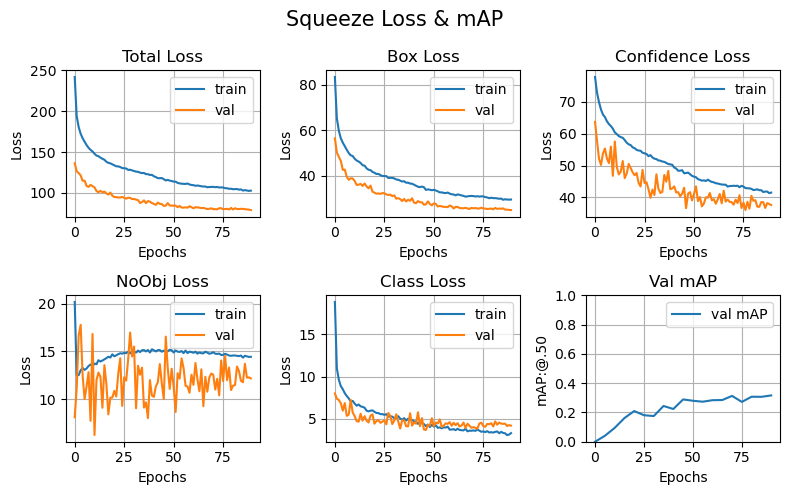

In [35]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(2,3, figsize=(8, 5))
fig.suptitle('Squeeze Loss & mAP', fontsize=15)

plt.subplot(2,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,2)
plt.plot(train_box_loss, label="train")
plt.plot(val_box_loss, label="val")
plt.title("Box Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,3)
plt.plot(train_confidence_loss, label="train")
plt.plot(val_confidence_loss, label="val")
plt.title("Confidence Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,4)
plt.plot(train_noobj_loss, label="train")
plt.plot(val_noobj_loss, label="val")
plt.title("NoObj Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,5)
plt.plot(train_class_loss, label="train")
plt.plot(val_class_loss, label="val")
plt.title("Class Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,6)
plt.plot(range(0, EPOCHS+1, 5), [0]+val_mAP, label="val mAP")
plt.title("Val mAP")
plt.ylim([0,1])
plt.xlabel("Epochs")
plt.ylabel("mAP:@.50")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + "squeeze_loss_ma.png")
plt.show()

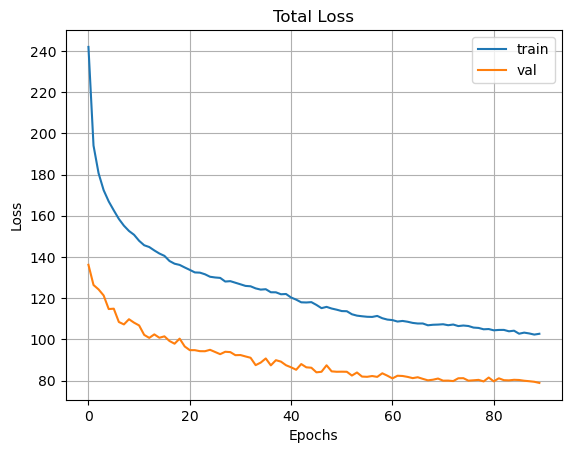

In [36]:
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig(log_path + "squeeze_loss_total.png")
plt.show()

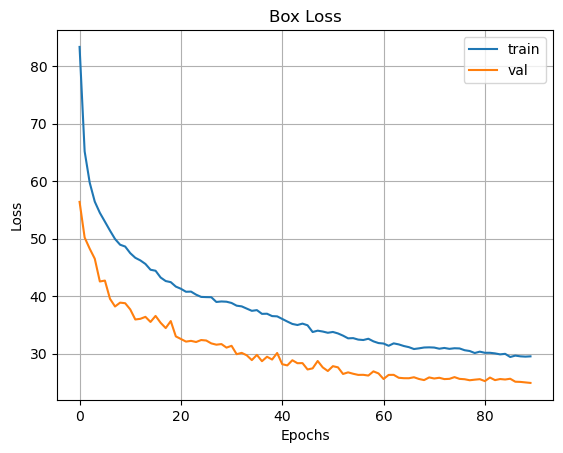

In [37]:
plt.plot(train_box_loss, label="train")
#plt.scatter(range(EPOCHS), train_box_loss)
plt.plot(val_box_loss, label="val")
#plt.scatter(range(EPOCHS), val_box_loss)
plt.title("Box Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig(log_path + "squeeze_loss_box.png")
plt.show()

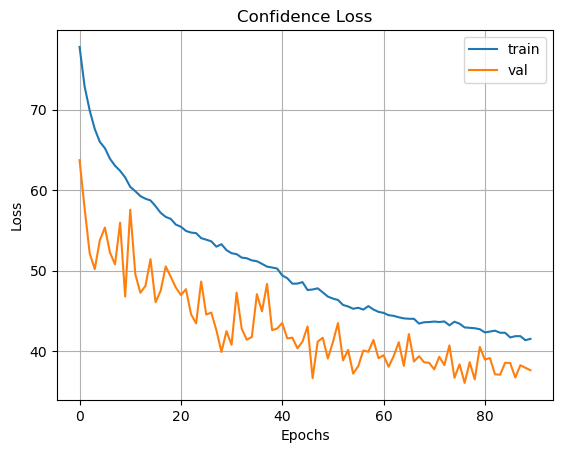

In [38]:
plt.plot(train_confidence_loss, label="train")
plt.plot(val_confidence_loss, label="val")
plt.title("Confidence Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig(log_path + "squeeze_loss_conf.png")
plt.show()

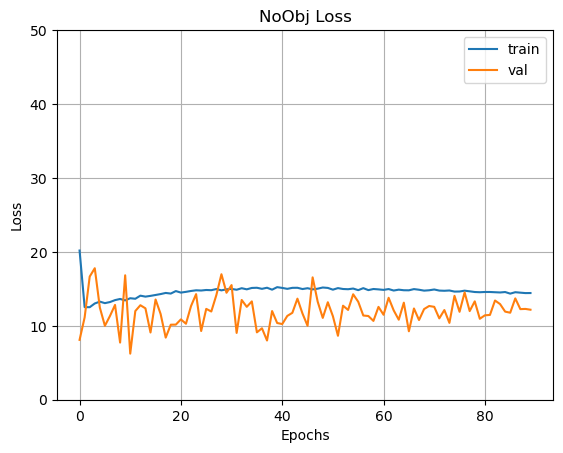

In [39]:
plt.plot(train_noobj_loss, label="train")
plt.plot(val_noobj_loss, label="val")
plt.title("NoObj Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0,50])
plt.legend()
plt.grid()
plt.savefig(log_path + "squeeze_loss_noobj.png")
plt.show()

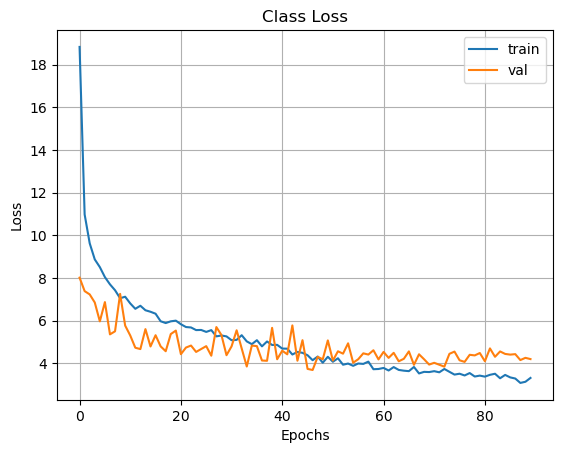

In [40]:
plt.plot(train_class_loss, label="train")
plt.plot(val_class_loss, label="val")
plt.title("Class Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig(log_path + "squeeze_loss_class.png")
plt.show()

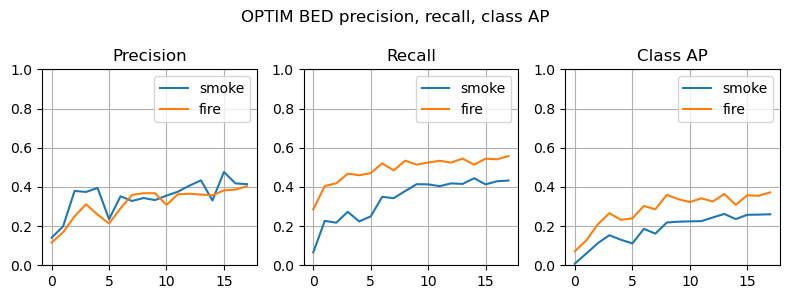

In [41]:
# val_class_AP
# val_class_precision
# val_class_recall

smoke_prec = []
fire_prec = []
for prec in val_class_precision:
    smoke_prec.append(prec[0])
    fire_prec.append(prec[1])

smoke_recall = []
fire_recall = []
for rec in val_class_recall:
    smoke_recall.append(rec[0])
    fire_recall.append(rec[1])

smoke_ap = []
fire_ap = []
for ap in val_class_AP:
    smoke_ap.append(ap[0])
    fire_ap.append(ap[1])

fig, axs = plt.subplots(1, 3, figsize=(8, 3))
fig.suptitle('OPTIM BED precision, recall, class AP')

plt.subplot(1, 3, 1)
plt.plot(smoke_prec, label="smoke")
plt.plot(fire_prec, label="fire")
plt.title("Precision")
plt.ylim([0,1])
plt.grid()
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(smoke_recall, label="smoke")
plt.plot(fire_recall, label="fire")
plt.title("Recall")
plt.ylim([0,1])
plt.grid()
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(smoke_ap, label="smoke")
plt.plot(fire_ap, label="fire")
plt.title("Class AP")
plt.ylim([0,1])
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig(log_path + "squeeze_precision_recall_classAP.png")
plt.show()

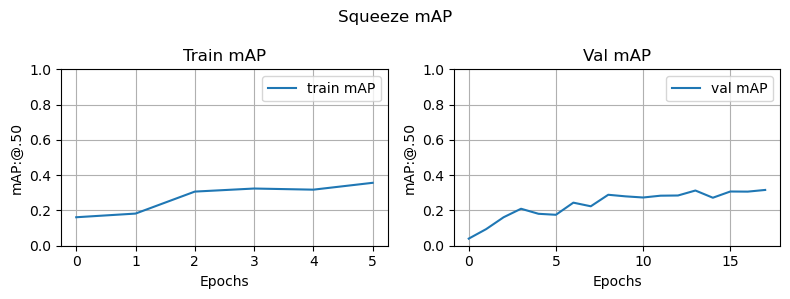

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
fig.suptitle('Squeeze mAP')

plt.subplot(1,2,1)
plt.plot(train_mAP, label="train mAP")
plt.title("Train mAP")
plt.ylim([0,1])
plt.xlabel("Epochs")
plt.ylabel("mAP:@.50")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(val_mAP, label="val mAP")
plt.title("Val mAP")
plt.ylim([0,1])
plt.xlabel("Epochs")
plt.ylabel("mAP:@.50")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + "squeeze_mAP.png")
plt.show()

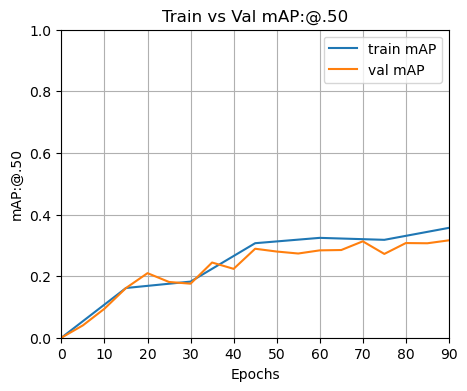

In [43]:
fig, axs = plt.subplots(figsize=(5, 4))

plt.plot(range(0, EPOCHS+1, 15), [0]+train_mAP, label="train mAP")
plt.plot(range(0, EPOCHS+1, 5), [0]+val_mAP, label="val mAP")
plt.title("Train vs Val mAP:@.50")
plt.xlim([0,EPOCHS])
plt.ylim([0,1])
plt.xlabel("Epochs")
plt.ylabel("mAP:@.50")
plt.legend()
plt.grid()

plt.savefig(log_path + "squeeze_mAP_together.png")
plt.show()